<a href="https://colab.research.google.com/github/kram254/6G-Network-Encryption-Machine-Learning-Model/blob/updates/6G_Network_Encryption_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading Data**

## **Mounting google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Processing models:  25%|██▌       | 1/4 [00:00<00:00,  6.78it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of 100 | elapsed:    0.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  10 out of 100 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  10 out of 100 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    0.0s finished
Processing models: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]


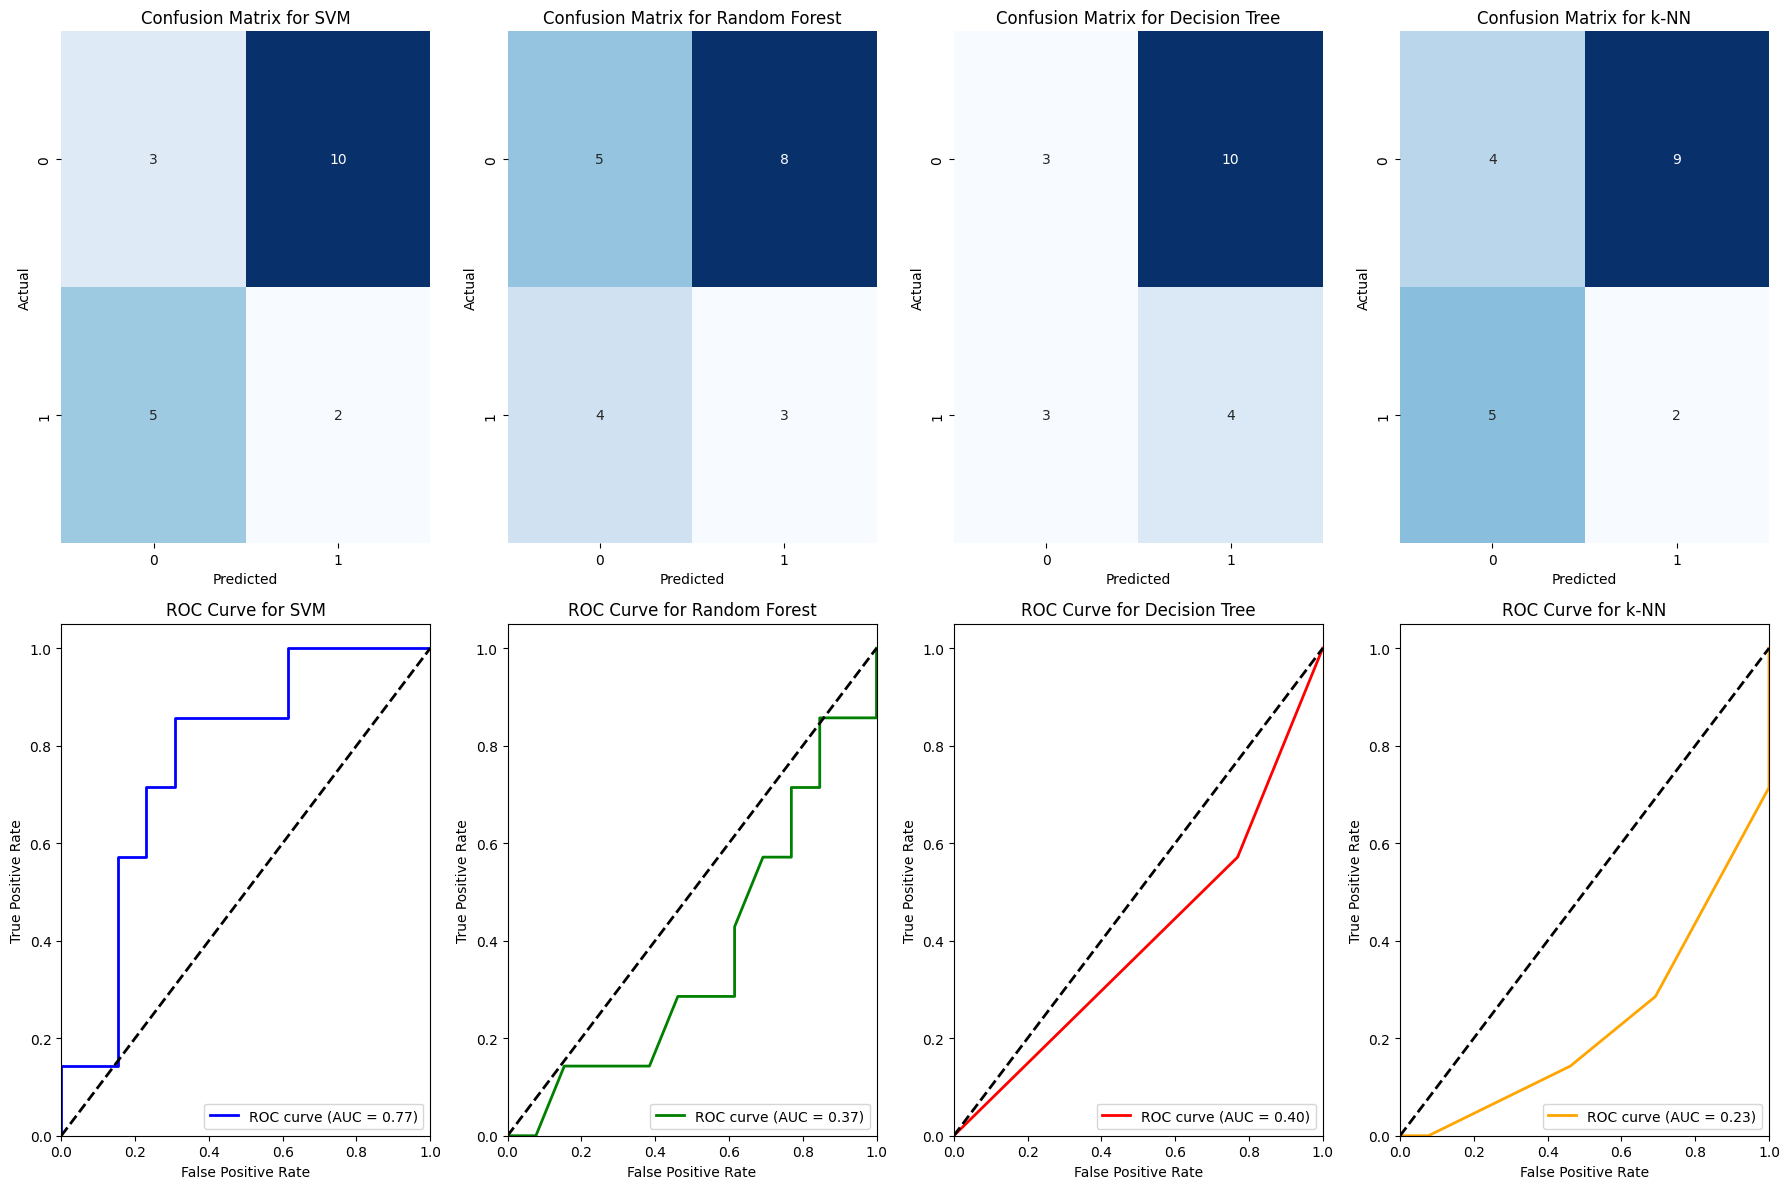

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import logging
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Dummy data for demonstration
X = np.random.rand(100, 10)
y = np.random.randint(0, 2, 100)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor
numeric_features = list(range(X.shape[1]))
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Models
models = {
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=1),
    "Decision Tree": DecisionTreeClassifier(),
    "k-NN": KNeighborsClassifier()
}

plt.figure(figsize=(18, 12))
colors = ["blue", "green", "red", "orange"]

for i, (name, model) in tqdm(enumerate(models.items()), total=len(models), desc="Processing models"):
    logger.info(f"Processing model: {name}")

    # Pipeline
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', model)])
    try:
        # Train the model
        model_pipeline.fit(X_train, y_train)
    except Exception as e:
        logger.error(f"Error training model {name}: {e}")
        continue

    # Predict and compute metrics
    try:
        y_pred = model_pipeline.predict(X_val)
        y_pred_prob = model_pipeline.predict_proba(X_val)[:, 1] if hasattr(model_pipeline, "predict_proba") else model_pipeline.decision_function(X_val)
    except Exception as e:
        logger.error(f"Error predicting with model {name}: {e}")
        continue

    # Confusion Matrix
    try:
        cm = confusion_matrix(y_val, y_pred)
        plt.subplot(2, 4, i + 1)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
    except Exception as e:
        logger.error(f"Error plotting confusion matrix for model {name}: {e}")

    # ROC Curve and AUC
    try:
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.subplot(2, 4, i + 5)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], "k--", lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title(f"ROC Curve for {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
    except Exception as e:
        logger.error(f"Error plotting ROC curve for model {name}: {e}")

plt.tight_layout()
plt.show()

Processing models:   0%|          | 0/6 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of 100 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  10 out of 100 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  10 out of 100 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    0.0s finished
Processing models: 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]


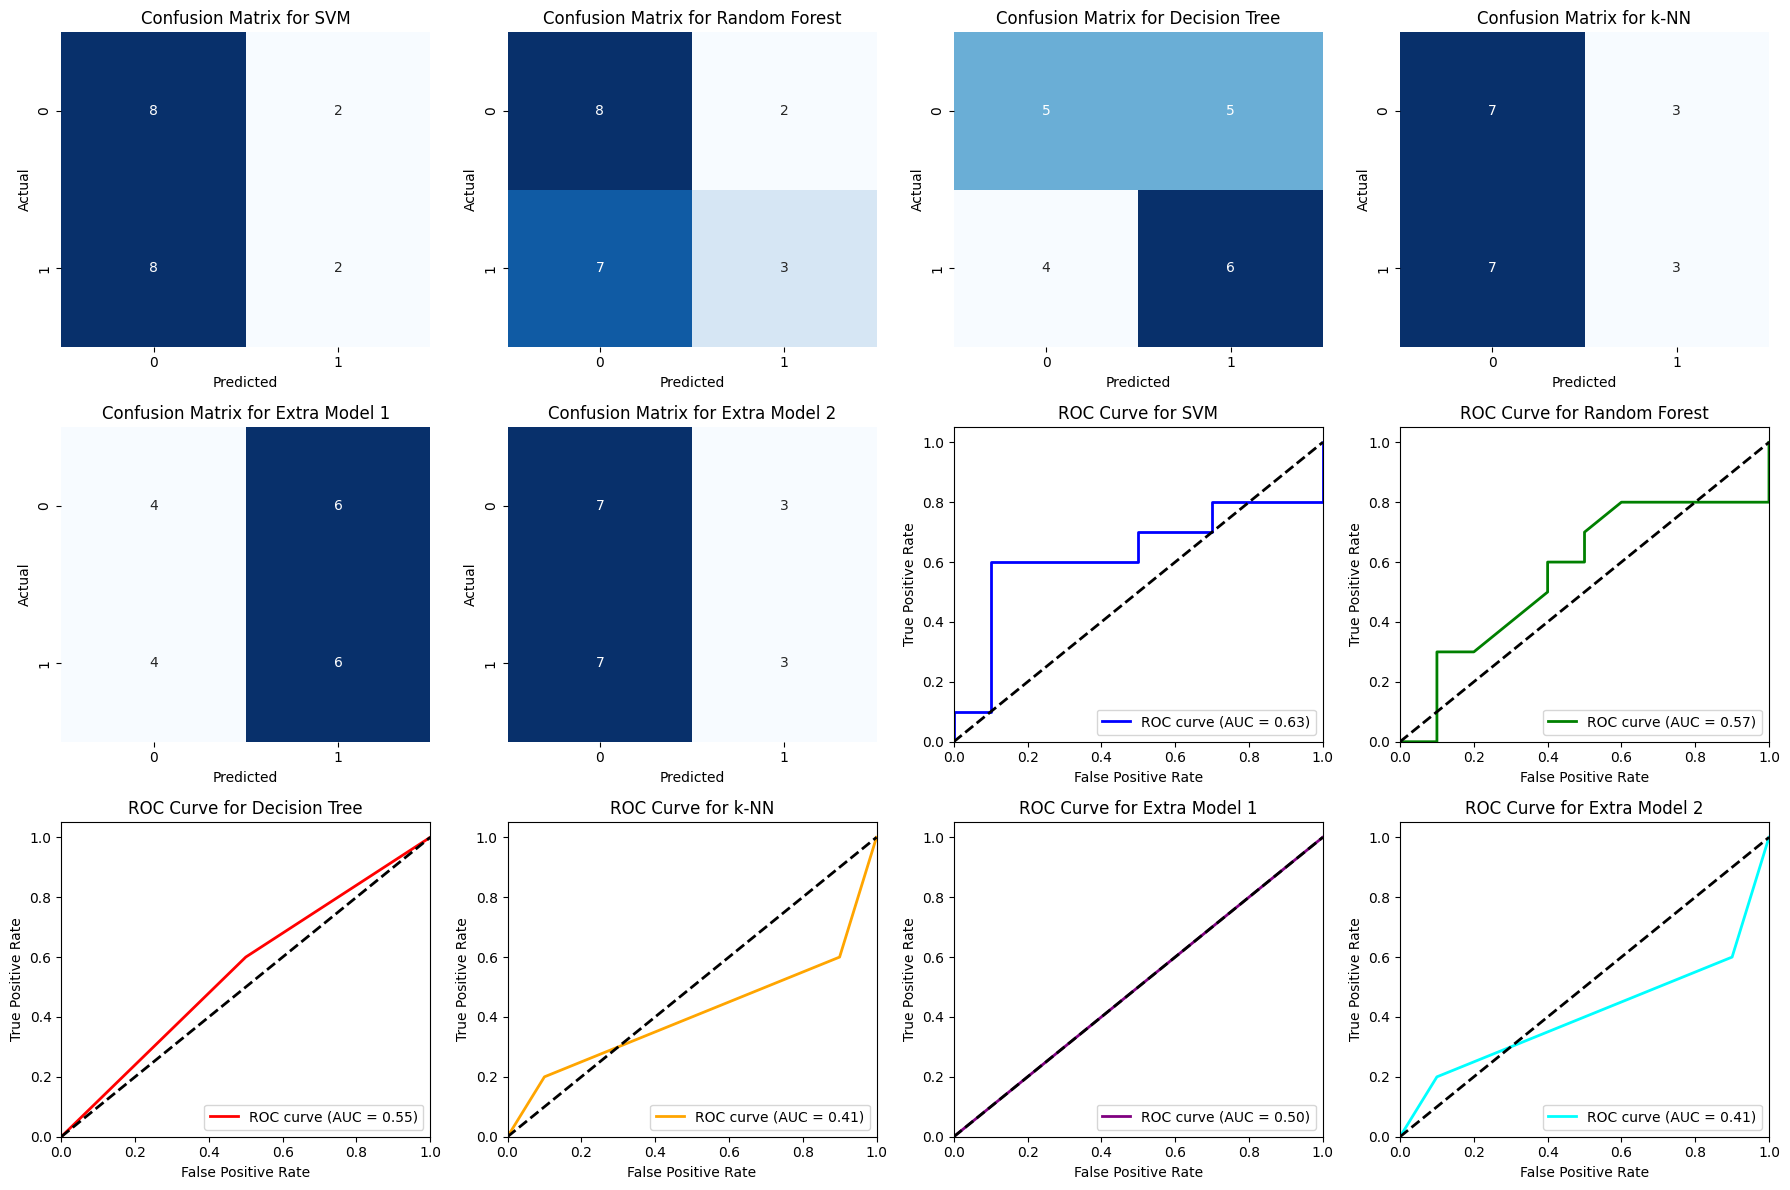

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import logging
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Dummy data for demonstration
X = np.random.rand(100, 10)
y = np.random.randint(0, 2, 100)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor
numeric_features = list(range(X.shape[1]))
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Models
models = {
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=1),
    "Decision Tree": DecisionTreeClassifier(),
    "k-NN": KNeighborsClassifier(),
    "Extra Model 1": DecisionTreeClassifier(),
    "Extra Model 2": KNeighborsClassifier()
}

plt.figure(figsize=(18, 12))
colors = ["blue", "green", "red", "orange", "purple", "cyan"]

for i, (name, model) in tqdm(enumerate(models.items()), total=len(models), desc="Processing models"):
    logger.info(f"Processing model: {name}")

    # Pipeline
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', model)])
    try:
        # Train the model
        model_pipeline.fit(X_train, y_train)
    except Exception as e:
        logger.error(f"Error training model {name}: {e}")
        continue

    # Predict and compute metrics
    try:
        y_pred = model_pipeline.predict(X_val)
        y_pred_prob = model_pipeline.predict_proba(X_val)[:, 1] if hasattr(model_pipeline, "predict_proba") else model_pipeline.decision_function(X_val)
    except Exception as e:
        logger.error(f"Error predicting with model {name}: {e}")
        continue

    # Confusion Matrix
    try:
        cm = confusion_matrix(y_val, y_pred)
        plt.subplot(3, 4, i + 1)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
    except Exception as e:
        logger.error(f"Error plotting confusion matrix for model {name}: {e}")

    # ROC Curve and AUC
    try:
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.subplot(3, 4, i + len(models) + 1)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], "k--", lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title(f"ROC Curve for {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
    except Exception as e:
        logger.error(f"Error plotting ROC curve for model {name}: {e}")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

nsl_kdd_train_path = '/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Train.csv'
nsl_kdd_test_path = '/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Test.csv'
nsl_kdd_col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

try:
    nsl_kdd_train = pd.read_csv(nsl_kdd_train_path, names=nsl_kdd_col_names, skiprows=1)
    nsl_kdd_test = pd.read_csv(nsl_kdd_test_path, names=nsl_kdd_col_names, skiprows=1)
except Exception as e:
    logger.error(f"Error reading NSL-KDD datasets: {e}")

# UNSW-NB15 datasets
unsw_files = ['/content/drive/MyDrive/6data/UNSW/UNSW-NB15_1.csv', '/content/drive/MyDrive/6data/UNSW/UNSW-NB15_2.csv',
              '/content/drive/MyDrive/6data/UNSW/UNSW-NB15_3.csv', '/content/drive/MyDrive/6data/UNSW/UNSW-NB15_4.csv']
unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
                  "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
                  "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
                  "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat", "Label"]

def read_and_process_csv(file_path, column_names, chunksize=10000):
    chunks = []
    try:
        for chunk in pd.read_csv(file_path, names=column_names, skiprows=1, chunksize=chunksize, low_memory=False):
            chunks.append(chunk)
    except Exception as e:
        logger.error(f"Error reading file {file_path}: {e}")
    return pd.concat(chunks, ignore_index=True)

unsw_frames = [read_and_process_csv(f, unsw_col_names) for f in unsw_files]
unsw_nb15 = pd.concat(unsw_frames, ignore_index=True)

def convert_mixed_types(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except ValueError as e:
                logger.warning(f"Error converting column {col} to numeric: {e}")
    return df

unsw_nb15 = convert_mixed_types(unsw_nb15)

# Combine datasets
try:
    combined_data = pd.concat([nsl_kdd_train, nsl_kdd_test, unsw_nb15], ignore_index=True)
except Exception as e:
    logger.error(f"Error combining datasets: {e}")

# Features and labels
X = combined_data.drop(columns=['label', 'Label', 'attack_cat', 'srcip', 'dstip'], errors='ignore')
y = combined_data[['label', 'Label', 'attack_cat']].fillna('').astype(str).agg('-'.join, axis=1)

# Fill missing values
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    X[col] = X[col].fillna(0)

# Encode categorical variables
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Encode labels
y = pd.factorize(y)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "k-NN": KNeighborsClassifier()
}

plt.figure(figsize=(18, 12))
colors = ["blue", "green", "red", "orange"]
for i, (name, model) in enumerate(models.items()):
    logger.info(f"Processing model: {name}")



    # Pipeline
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', model)])
    try:
        # Train the model
        model_pipeline.fit(X_train, y_train)
    except Exception as e:
        logger.error(f"Error training model {name}: {e}")
        continue

    # Predict and compute metrics
    try:
        y_pred = model_pipeline.predict(X_val)
        y_pred_prob = model_pipeline.predict_proba(X_val) if hasattr(model_pipeline, "predict_proba") else model_pipeline.decision_function(X_val)
    except Exception as e:
        logger.error(f"Error predicting with model {name}: {e}")
        continue

    # Confusion Matrix
    try:
        cm = confusion_matrix(y_val, y_pred)
        plt.subplot(2, 4, i + 1)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
    except Exception as e:
        logger.error(f"Error plotting confusion matrix for model {name}: {e}")

    # ROC Curve and AUC
    try:
        if y_val.ndim > 1 and y_val.shape[1] > 2:  # Multi-class
            lb = LabelBinarizer()
            y_val_bin = lb.fit_transform(np.argmax(y_val, axis=1))
            if hasattr(model_pipeline, "predict_proba"):
                y_score = model_pipeline.predict_proba(X_val)
            else:
                y_score = model_pipeline.decision_function(X_val)

            # Compute ROC curve and AUC for each class
            fpr = {}
            tpr = {}
            roc_auc = {}
            for j in range(y_val.shape[1]):
                fpr[j], tpr[j], _ = roc_curve(y_val_bin[:, j], y_score[:, j])
                roc_auc[j] = auc(fpr[j], tpr[j])

            # Plot ROC curve for each class
            plt.subplot(2, 4, i + 5)
            for j in range(y_val.shape[1]):
                plt.plot(fpr[j], tpr[j], label=f'Class {j} (AUC = {roc_auc[j]:.2f})', color=colors[j % len(colors)])
            plt.plot([0, 1], [0, 1], "k--")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.title(f"ROC Curve for {name}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
        else:  # Binary
            fpr, tpr, _ = roc_curve(np.argmax(y_val, axis=1), y_pred_prob)
            roc_auc = auc(fpr, tpr)
            plt.subplot(2, 4, i + 5)
            plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], "k--", lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.title(f"ROC Curve for {name}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
    except Exception as e:
        logger.error(f"Error plotting ROC curve for model {name}: {e}")

plt.tight_layout()
plt.show()


























# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# import logging

# # Configure logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger(__name__)

# nsl_kdd_train_path = '/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Train.csv'
# nsl_kdd_test_path = '/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Test.csv'
# nsl_kdd_col_names = ["duration","protocol_type","service","flag","src_bytes",
#     "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
#     "logged_in","num_compromised","root_shell","su_attempted","num_root",
#     "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
#     "is_host_login","is_guest_login","count","srv_count","serror_rate",
#     "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
#     "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
#     "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
#     "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
#     "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# try:
#     nsl_kdd_train = pd.read_csv(nsl_kdd_train_path, names=nsl_kdd_col_names, skiprows=1)
#     nsl_kdd_test = pd.read_csv(nsl_kdd_test_path, names=nsl_kdd_col_names, skiprows=1)
# except Exception as e:
#     logger.error(f"Error reading NSL-KDD datasets: {e}")

# # UNSW-NB15 datasets
# unsw_files = ['/content/drive/MyDrive/6data/UNSW/UNSW-NB15_1.csv', '/content/drive/MyDrive/6data/UNSW/UNSW-NB15_2.csv',
#               '/content/drive/MyDrive/6data/UNSW/UNSW-NB15_3.csv', '/content/drive/MyDrive/6data/UNSW/UNSW-NB15_4.csv']
# unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
#                   "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
#                   "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
#                   "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat", "Label"]

# def read_and_process_csv(file_path, column_names, chunksize=10000):
#     chunks = []
#     try:
#         for chunk in pd.read_csv(file_path, names=column_names, skiprows=1, chunksize=chunksize, low_memory=False):
#             chunks.append(chunk)
#     except Exception as e:
#         logger.error(f"Error reading file {file_path}: {e}")
#     return pd.concat(chunks, ignore_index=True)

# unsw_frames = [read_and_process_csv(f, unsw_col_names) for f in unsw_files]
# unsw_nb15 = pd.concat(unsw_frames, ignore_index=True)

# def convert_mixed_types(df):
#     for col in df.columns:
#         if df[col].dtype == 'object':
#             try:
#                 df[col] = pd.to_numeric(df[col], errors='coerce')
#             except ValueError as e:
#                 logger.warning(f"Error converting column {col} to numeric: {e}")
#     return df

# unsw_nb15 = convert_mixed_types(unsw_nb15)

# # Combine datasets
# try:
#     combined_data = pd.concat([nsl_kdd_train, nsl_kdd_test, unsw_nb15], ignore_index=True)
# except Exception as e:
#     logger.error(f"Error combining datasets: {e}")

# # Features and labels
# X = combined_data.drop(columns=['label', 'Label', 'attack_cat', 'srcip', 'dstip'], errors='ignore')
# y = combined_data[['label', 'Label', 'attack_cat']].fillna('').astype(str).agg('-'.join, axis=1)

# # Fill missing values
# for col in X.select_dtypes(include=['float64', 'int64']).columns:
#     X[col] = X[col].fillna(0)

# # Encode categorical variables
# categorical_features = X.select_dtypes(include=['object']).columns
# numeric_features = X.select_dtypes(exclude=['object']).columns

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# # Encode labels
# y = pd.factorize(y)[0]
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # Models
# models = {     "SVM": SVC(probability=True),
#     "Random Forest": RandomForestClassifier(),
#     "Decision Tree": DecisionTreeClassifier(),
#     "k-NN": KNeighborsClassifier()
# }

# plt.figure(figsize=(18, 12))
# colors = ["blue", "green", "red", "orange"]
# for i, (name, model) in enumerate(models.items()):
#     logger.info(f"Processing model: {name}")

#     # Pipeline
#     model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                      ('classifier', model)])
#     try:
#         # Train the model
#         model_pipeline.fit(X_train, y_train)
#     except Exception as e:
#         logger.error(f"Error training model {name}: {e}")
#         continue

#     # Predict and compute metrics
#     try:
#         y_pred = model_pipeline.predict(X_val)
#         y_pred_prob = model_pipeline.predict_proba(X_val) if hasattr(model_pipeline, "predict_proba") else model_pipeline.decision_function(X_val)
#     except Exception as e:
#         logger.error(f"Error predicting with model {name}: {e}")
#         continue

#     # Confusion Matrix
#     try:
#         cm = confusion_matrix(y_val, y_pred)
#         plt.subplot(2, 4, i + 1)
#         sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
#         plt.title(f"Confusion Matrix for {name}")
#         plt.xlabel("Predicted")
#         plt.ylabel("Actual")
#     except Exception as e:
#         logger.error(f"Error plotting confusion matrix for model {name}: {e}")

#     # ROC Curve and AUC
#     try:
#         if y_val.ndim > 1 and y_val.shape[1] > 2:  # Multi-class
#             lb = LabelBinarizer()
#             y_val_bin = lb.fit_transform(np.argmax(y_val, axis=1))
#             if hasattr(model_pipeline, "predict_proba"):
#                 y_score = model_pipeline.predict_proba(X_val)
#             else:
#                 y_score = model_pipeline.decision_function(X_val)

#             # Compute ROC curve and AUC for each class
#             fpr = {}
#             tpr = {}
#             roc_auc = {}
#             for j in range(y_val.shape[1]):
#                 fpr[j], tpr[j], _ = roc_curve(y_val_bin[:, j], y_score[:, j])
#                 roc_auc[j] = auc(fpr[j], tpr[j])

#             # Plot ROC curve for each class
#             plt.subplot(2, 4, i + 5)
#             for j in range(y_val.shape[1]):
#                 plt.plot(fpr[j], tpr[j], label=f'Class {j} (AUC = {roc_auc[j]:.2f})', color=colors[j % len(colors)])
#             plt.plot([0, 1], [0, 1], "k--")
#             plt.xlim([0.0, 1.0])
#             plt.ylim([0.0, 1.05])
#             plt.title(f"ROC Curve for {name}")
#             plt.xlabel("False Positive Rate")
#             plt.ylabel("True Positive Rate")
#             plt.legend(loc="lower right")
#         else:  # Binary
#             fpr, tpr, _ = roc_curve(np.argmax(y_val, axis=1), y_pred_prob)
#             roc_auc = auc(fpr, tpr)
#             plt.subplot(2, 4, i + 5)
#             plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
#             plt.plot([0, 1], [0, 1], "k--", lw=2)
#             plt.xlim([0.0, 1.0])
#             plt.ylim([0.0, 1.05])
#             plt.title(f"ROC Curve for {name}")
#             plt.xlabel("False Positive Rate")
#             plt.ylabel("True Positive Rate")
#             plt.legend(loc="lower right")
#     except Exception as e:
#         logger.error(f"Error plotting ROC curve for model {name}: {e}")

# plt.tight_layout()
# plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

nsl_kdd_train_path = '/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Train.csv'
nsl_kdd_test_path = '/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Test.csv'
nsl_kdd_col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

nsl_kdd_train = pd.read_csv(nsl_kdd_train_path, names=nsl_kdd_col_names, skiprows=1)
nsl_kdd_test = pd.read_csv(nsl_kdd_test_path, names=nsl_kdd_col_names, skiprows=1)

# UNSW-NB15 datasets
unsw_files = ['/content/drive/MyDrive/6data/UNSW/UNSW-NB15_1.csv', '/content/drive/MyDrive/6data/UNSW/UNSW-NB15_2.csv',
              '/content/drive/MyDrive/6data/UNSW/UNSW-NB15_3.csv', '/content/drive/MyDrive/6data/UNSW/UNSW-NB15_4.csv']
unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
                  "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
                  "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
                  "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat", "Label"]


def read_and_process_csv(file_path, column_names, chunksize=10000):
    chunks = []
    for chunk in pd.read_csv(file_path, names=column_names, skiprows=1, chunksize=chunksize, low_memory=False):
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

unsw_frames = [read_and_process_csv(f, unsw_col_names) for f in unsw_files]
unsw_nb15 = pd.concat(unsw_frames, ignore_index=True)

def convert_mixed_types(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except ValueError:
                pass
    return df

unsw_nb15 = convert_mixed_types(unsw_nb15)

# Combine datasets
combined_data = pd.concat([nsl_kdd_train, nsl_kdd_test, unsw_nb15], ignore_index=True)

# Features and labels
X = combined_data.drop(columns=['label', 'Label', 'attack_cat', 'srcip', 'dstip'], errors='ignore')
y = combined_data[['label', 'Label', 'attack_cat']].fillna('').astype(str).agg('-'.join, axis=1)

# Fill missing values
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    X[col] = X[col].fillna(0)

# Encode categorical variables like a boss
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Encode labels
y = pd.factorize(y)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "k-NN": KNeighborsClassifier()
}

plt.figure(figsize=(18, 12))
colors = ["blue", "green", "red", "orange"]
for i, (name, model) in enumerate(models.items()):

    # Pipeline
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', model)])
    # Train the model, like a boss
    model_pipeline.fit(X_train, y_train)

    # Predict and compute metrics
    y_pred = model_pipeline.predict(X_val)
    y_pred_prob = model_pipeline.predict_proba(X_val) if hasattr(model_pipeline, "predict_proba") else model_pipeline.decision_function(X_val)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.subplot(2, 4, i + 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # ROC Curve and AUC
    if y_val.ndim > 1 and y_val.shape[1] > 2:  # Multi-class
        lb = LabelBinarizer()
        y_val_bin = lb.fit_transform(np.argmax(y_val, axis=1))
        if hasattr(model_pipeline, "predict_proba"):
            y_score = model_pipeline.predict_proba(X_val)
        else:
            y_score = model_pipeline.decision_function(X_val)

        # Compute ROC curve and AUC for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        for j in range(y_val.shape[1]):
            fpr[j], tpr[j], _ = roc_curve(y_val_bin[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

        # Plot ROC curve for each class
        plt.subplot(2, 4, i + 5)
        for j in range(y_val.shape[1]):
            plt.plot(fpr[j], tpr[j], label=f'Class {j} (AUC = {roc_auc[j]:.2f})', color=colors[j % len(colors)])
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title(f"ROC Curve for {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
    else:  # Binary
        fpr, tpr, _ = roc_curve(np.argmax(y_val, axis=1), y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.subplot(2, 4, i + 5)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], "k--", lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title(f"ROC Curve for {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")

plt.tight_layout()
plt.show()








# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# # Load NSL-KDD datasets
# nsl_kdd_train_path = '/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Train.csv'
# nsl_kdd_test_path = '/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Test.csv'
# nsl_kdd_col_names = ["duration","protocol_type","service","flag","src_bytes",
#     "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
#     "logged_in","num_compromised","root_shell","su_attempted","num_root",
#     "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
#     "is_host_login","is_guest_login","count","srv_count","serror_rate",
#     "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
#     "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
#     "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
#     "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
#     "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# nsl_kdd_train = pd.read_csv(nsl_kdd_train_path, names=nsl_kdd_col_names, skiprows=1)
# nsl_kdd_test = pd.read_csv(nsl_kdd_test_path, names=nsl_kdd_col_names, skiprows=1)

# # Load UNSW-NB15 datasets
# unsw_files = ['/content/drive/MyDrive/6data/UNSW/UNSW-NB15_1.csv', '/content/drive/MyDrive/6data/UNSW/UNSW-NB15_2.csv',
#               '//content/drive/MyDrive/6data/UNSW/UNSW-NB15_3.csv', '/content/drive/MyDrive/6data/UNSW/UNSW-NB15_4.csv']
# unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
#                   "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
#                   "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
#                   "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat", "Label"]
# unsw_frames = [pd.read_csv(f, names=unsw_col_names, skiprows=1) for f in unsw_files]
# unsw_nb15 = pd.concat(unsw_frames, ignore_index=True)

# # Handle mixed types by converting to appropriate types
# unsw_nb15['sport'] = pd.to_numeric(unsw_nb15['sport'], errors='coerce')
# unsw_nb15['dsport'] = pd.to_numeric(unsw_nb15['dsport'], errors='coerce')

# # Combine datasets
# combined_data = pd.concat([nsl_kdd_train, nsl_kdd_test, unsw_nb15], ignore_index=True)

# # Features and labels (adjust based on actual dataset column names)
# X = combined_data.drop(columns=['label', 'Label', 'attack_cat', 'srcip', 'dstip'], errors='ignore')
# y = combined_data[['label', 'Label', 'attack_cat']].fillna('').astype(str).agg('-'.join, axis=1)

# # Fill missing values in numerical columns
# for col in X.select_dtypes(include=['float64', 'int64']).columns:
#     X[col] = X[col].fillna(0)

# # Encode categorical variables and standardize numerical features
# categorical_features = X.select_dtypes(include=['object']).columns
# numeric_features = X.select_dtypes(exclude=['object']).columns

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# # Encode labels
# lb = LabelBinarizer()
# y = lb.fit_transform(y)

# # Split data
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize models
# models = {
#     "SVM": SVC(probability=True),
#     "Random Forest": RandomForestClassifier(),
#     "Decision Tree": DecisionTreeClassifier(),
#     "k-NN": KNeighborsClassifier()
# }

# # Plotting setup
# plt.figure(figsize=(18, 12))

# # Colors for ROC curves
# colors = ["blue", "green", "red", "orange"]

# for i, (name, model) in enumerate(models.items()):
#     # Create pipeline for each model
#     model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                      ('classifier', model)])
#     # Train the model
#     model_pipeline.fit(X_train, np.argmax(y_train, axis=1))

#     # Predict and compute metrics
#     y_pred = model_pipeline.predict(X_val)
#     y_pred_prob = model_pipeline.predict_proba(X_val) if hasattr(model_pipeline, "predict_proba") else model_pipeline.decision_function(X_val)

#     # Confusion Matrix
#     cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred)
#     plt.subplot(2, 4, i + 1)
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
#     plt.title(f"Confusion Matrix for {name}")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")

#     # ROC Curve and AUC
#     if y_val.shape[1] > 2:  # Multi-class
#         lb = LabelBinarizer()
#         y_val_bin = lb.fit_transform(np.argmax(y_val, axis=1))
#         if hasattr(model_pipeline, "predict_proba"):
#             y_score = model_pipeline.predict_proba(X_val)
#         else:
#             y_score = model_pipeline.decision_function(X_val)

#         # Compute ROC curve and AUC for each class
#         fpr = {}
#         tpr = {}
#         roc_auc = {}
#         for j in range(y_val.shape[1]):
#             fpr[j], tpr[j], _ = roc_curve(y_val_bin[:, j], y_score[:, j])
#             roc_auc[j] = auc(fpr[j], tpr[j])

#         # Plot ROC curve for each class
#         plt.subplot(2, 4, i + 5)
#         for j in range(y_val.shape[1]):
#             plt.plot(fpr[j], tpr[j], label=f'Class {j} (AUC = {roc_auc[j]:.2f})', color=colors[j % len(colors)])
#         plt.plot([0, 1], [0, 1], "k--")
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.05])
#         plt.title(f"ROC Curve for {name}")
#         plt.xlabel("False Positive Rate")
#         plt.ylabel("True Positive Rate")
#         plt.legend(loc="lower right")
#     else:  # Binary
#         fpr, tpr, _ = roc_curve(np.argmax(y_val, axis=1), y_pred_prob)
#         roc_auc = auc(fpr, tpr)
#         plt.subplot(2, 4, i + 5)
#         plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
#         plt.plot([0, 1], [0, 1], "k--", lw=2)
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.05])
#         plt.title(f"ROC Curve for {name}")
#         plt.xlabel("False Positive Rate")
#         plt.ylabel("True Positive Rate")
#         plt.legend(loc="lower right")

# plt.tight_layout()
# plt.show()


### Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**NSL_KDD dataset**

In [ ]:
import pandas as pd

nsl_kdd_col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

nsl_kdd_train = pd.read_csv('/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Train.csv', names=nsl_kdd_col_names)
nsl_kdd_test = pd.read_csv('/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Test.csv', names=nsl_kdd_col_names)

nsl_kdd = pd.concat([nsl_kdd_train, nsl_kdd_test], ignore_index=True)

print(nsl_kdd.head(10))


   duration protocol_type     service flag  src_bytes  dst_bytes  land  \
0         0           tcp    ftp_data   SF        491          0     0   
1         0           udp       other   SF        146          0     0   
2         0           tcp     private   S0          0          0     0   
3         0           tcp        http   SF        232       8153     0   
4         0           tcp        http   SF        199        420     0   
5         0           tcp     private  REJ          0          0     0   
6         0           tcp     private   S0          0          0     0   
7         0           tcp     private   S0          0          0     0   
8         0           tcp  remote_job   S0          0          0     0   
9         0           tcp     private   S0          0          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2       

# **UNSW**

In [ ]:
unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
                  "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
                  "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
                  "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat", "Label"]

unsw_frames = [pd.read_csv(f'/content/drive/MyDrive/6data/UNSW/UNSW-NB15_{i}.csv', names=unsw_col_names) for i in range(1, 5)]

unsw_nb15 = pd.concat(unsw_frames, ignore_index=True)

print(unsw_nb15.head(5))


<ipython-input-3-51b8c50f527c>:6: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  unsw_frames = [pd.read_csv(f'/content/drive/MyDrive/6data/UNSW/UNSW-NB15_{i}.csv', names=unsw_col_names) for i in range(1, 5)]
<ipython-input-3-51b8c50f527c>:6: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  unsw_frames = [pd.read_csv(f'/content/drive/MyDrive/6data/UNSW/UNSW-NB15_{i}.csv', names=unsw_col_names) for i in range(1, 5)]


        srcip  sport          dstip dsport proto state       dur  sbytes  \
0  59.166.0.0   1390  149.171.126.6     53   udp   CON  0.001055     132   
1  59.166.0.0  33661  149.171.126.9   1024   udp   CON  0.036133     528   
2  59.166.0.6   1464  149.171.126.7     53   udp   CON  0.001119     146   
3  59.166.0.5   3593  149.171.126.5     53   udp   CON  0.001209     132   
4  59.166.0.3  49664  149.171.126.0     53   udp   CON  0.001169     146   

   dbytes  sttl  ...  ct_ftp_cmd  ct_srv_src  ct_srv_dst ct_dst_ltm  \
0     164    31  ...           0           3           7          1   
1     304    31  ...           0           2           4          2   
2     178    31  ...           0          12           8          1   
3     164    31  ...           0           6           9          1   
4     178    31  ...           0           7           9          1   

   ct_src_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  attack_cat  \
0           3                 1    

# **cic_ids17**

In [ ]:
import pandas as pd
import gc


cic_ids17_a_col_names = ["Destination Port", "Flow Duration", "Total Fwd Packets", "Total Backward Packets", "Total Length of Fwd Packets", "Total Length of Bwd Packets",
                         "Fwd Packet Length Max", "Fwd Packet Length Min", "Fwd Packet Length Mean", "Fwd Packet Length Std", "Bwd Packet Length Max", "Bwd Packet Length Min",
                         "Bwd Packet Length Mean", "Bwd Packet Length Std", "Flow Bytes/s", "Flow Packets/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max", "Flow IAT Min",
                         "Fwd IAT Total", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min", "Bwd IAT Total", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max",
                         "Bwd IAT Min", "Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags", "Fwd Header Length", "Bwd Header Length", "Fwd Packets/s",
                         "Bwd Packets/s", "Min Packet Length", "Max Packet Length", "Packet Length Mean", "Packet Length Std", "Packet Length Variance", "FIN Flag Count",
                         "SYN Flag Count", "RST Flag Count", "PSH Flag Count", "ACK Flag Count", "URG Flag Count", "CWE Flag Count", "ECE Flag Count", "Down/Up Ratio",
                         "Average Packet Size", "Avg Fwd Segment Size", "Avg Bwd Segment Size", "Fwd Header Length.1", "Fwd Avg Bytes/Bulk", "Fwd Avg Packets/Bulk",
                         "Fwd Avg Bulk Rate", "Bwd Avg Bytes/Bulk", "Bwd Avg Packets/Bulk", "Bwd Avg Bulk Rate", "Subflow Fwd Packets", "Subflow Fwd Bytes",
                         "Subflow Bwd Packets", "Subflow Bwd Bytes", "Init_Win_bytes_forward", "Init_Win_bytes_backward", "act_data_pkt_fwd", "min_seg_size_forward",
                         "Active Mean", "Active Std", "Active Max", "Active Min", "Idle Mean", "Idle Std", "Idle Max", "Idle Min", "Label"]

cic_ids17_a_files = ["Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
                     "Friday-WorkingHours-Morning.pcap_ISCX.csv", "Monday-WorkingHours.pcap_ISCX.csv", "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
                     "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", "Tuesday-WorkingHours.pcap_ISCX.csv", "Wednesday-workingHours.pcap_ISCX.csv"]

# cic_ids17_a_frames = [pd.read_csv(f'/content/drive/MyDrive/6data/CIC_IDS17/dataA/{file}', names=cic_ids17_a_col_names) for file in cic_ids17_a_files]

def read_and_concat_in_chunks(file_path, chunk_size, concat_df=None):
    for chunk in pd.read_csv(file_path, names=cic_ids17_a_col_names, chunksize=chunk_size):
        concat_df = pd.concat([concat_df, chunk], ignore_index=True) if concat_df is not None else chunk
        gc.collect()  # garbage collector after each chunk to free up memory
    return concat_df

cic_ids17_a = None

for file in cic_ids17_a_files:
    file_path = f'/content/drive/MyDrive/6data/CIC_IDS17/dataA/{file}'
    cic_ids17_a = read_and_concat_in_chunks(file_path, chunk_size=10000, concat_df=cic_ids17_a)

print(cic_ids17_a.head())


In [ ]:
import os
import gc
import pandas as pd

cic_ids17_b_col_names = ["Flow ID", "Source IP", "Source Port", "Destination IP", "Destination Port", "Protocol", "Timestamp", "Flow Duration", "Total Fwd Packets",
                         "Total Backward Packets", "Total Length of Fwd Packets", "Total Length of Bwd Packets", "Fwd Packet Length Max", "Fwd Packet Length Min",
                         "Fwd Packet Length Mean", "Fwd Packet Length Std", "Bwd Packet Length Max", "Bwd Packet Length Min", "Bwd Packet Length Mean", "Bwd Packet Length Std",
                         "Flow Bytes/s", "Flow Packets/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max", "Flow IAT Min", "Fwd IAT Total", "Fwd IAT Mean", "Fwd IAT Std",
                         "Fwd IAT Max", "Fwd IAT Min", "Bwd IAT Total", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min", "Fwd PSH Flags", "Bwd PSH Flags",
                         "Fwd URG Flags", "Bwd URG Flags", "Fwd Header Length", "Bwd Header Length", "Fwd Packets/s", "Bwd Packets/s", "Min Packet Length", "Max Packet Length",
                         "Packet Length Mean", "Packet Length Std", "Packet Length Variance", "FIN Flag Count", "SYN Flag Count", "RST Flag Count", "PSH Flag Count",
                         "ACK Flag Count", "URG Flag Count", "CWE Flag Count", "ECE Flag Count", "Down/Up Ratio", "Average Packet Size", "Avg Fwd Segment Size",
                         "Avg Bwd Segment Size", "Fwd Header Length.1", "Fwd Avg Bytes/Bulk", "Fwd Avg Packets/Bulk", "Fwd Avg Bulk Rate", "Bwd Avg Bytes/Bulk",
                         "Bwd Avg Packets/Bulk", "Bwd Avg Bulk Rate", "Subflow Fwd Packets", "Subflow Fwd Bytes", "Subflow Bwd Packets", "Subflow Bwd Bytes",
                         "Init_Win_bytes_forward", "Init_Win_bytes_backward", "act_data_pkt_fwd", "min_seg_size_forward", "Active Mean", "Active Std", "Active Max",
                         "Active Min", "Idle Mean", "Idle Std", "Idle Max", "Idle Min", "Label"]

cic_ids17_b_files = ["Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", "Friday-WorkingHours-Morning.pcap_ISCX.csv",
                     "Monday-WorkingHours.pcap_ISCX.csv", "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
                    #  "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", "Tuesday-WorkingHours.pcap_ISCX.csv", "Wednesday-workingHours.pcap_ISCX.csv"
                     ]


processed_data_dir = '/content/drive/MyDrive/6data/CIC_IDS17/dataB/processed/'
if not os.path.exists(processed_data_dir):
    os.makedirs(processed_data_dir)

def process_and_save_chunks(file_path, chunk_size, processed_data_dir):
    for i, chunk in enumerate(pd.read_csv(file_path, names=cic_ids17_b_col_names, chunksize=chunk_size, encoding='ISO-8859-1')):
        # Perform preprocessing on the chunk

        chunk.to_csv(f'{processed_data_dir}processed_chunk_{i}.csv', index=False)
        gc.collect()  # garbage collector after each chunk to free up memory

for file in cic_ids17_b_files:
    file_path = f'/content/drive/MyDrive/6data/CIC_IDS17/dataB/{file}'
    process_and_save_chunks(file_path, chunk_size=10000, processed_data_dir=processed_data_dir)

print("All files have been processed and saved in chunks.")


In [ ]:
# processed_files = [os.path.join(processed_data_dir, f) for f in os.listdir(processed_data_dir) if f.startswith('processed_chunk_')]

# # Ensure there are processed files
# if processed_files:
#     # Option 1: Read the head of the first file
#     first_chunk = pd.read_csv(processed_files[0])
#     print("First 10 rows of the first processed chunk:")
#     print(first_chunk.head(10))

#     # Option 2: If you want to read the first 10 rows from each file and print them
#     # for file in processed_files:
#     #     chunk = pd.read_csv(file)
#     #     print(f"First 10 rows of {os.path.basename(file)}:")
#     #     print(chunk.head(10))
#     #     print("\n-------------------------------------------------------\n")

# else:
#     print("No processed chunk files found in the specified directory.")

# **Describe() and Info() the data**

In [ ]:
# print("NSL-KDD Dataset:")
# print(nsl_kdd.info())
# print(nsl_kdd.describe())

# print("\nUNSW-NB15 Dataset:")
# print(unsw_nb15.info())
# print(unsw_nb15.describe())

# processed_data_dir = '/content/drive/MyDrive/6data/CIC_IDS17/dataB/processed/'

# processed_files = [os.path.join(processed_data_dir, f) for f in os.listdir(processed_data_dir) if f.startswith('processed_chunk_')]

# if processed_files:
#     first_chunk = pd.read_csv(processed_files[0])

#     print("Info of the first processed chunk:")
#     first_chunk.info()

#     print("\nDescription of the first processed chunk:")
#     print(first_chunk.describe())

# else:
#     print("No processed chunk files found in the specified directory.")



# **Heatmap of Correlation Matrix**

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 8))
# correlation_matrix = nsl_kdd.corr()
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
# plt.title('NSL-KDD Correlation Matrix')
# plt.show()


# **Boxplots for Feature Distribution Across Classes**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='label', y='src_bytes', data=nsl_kdd)
plt.title('Distribution of src_bytes Across Classes in NSL-KDD')
plt.xticks(rotation=45)
plt.show()


# **Feature Importance from Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

nsl_kdd_col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

X = nsl_kdd.drop('label', axis=1)
y = nsl_kdd['label']

X = pd.get_dummies(X)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

plt.figure(figsize=(10, 8))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in NSL-KDD Dataset")
plt.show()


# **Milestone 2**

# **Training**

#### Define model architectures

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Define the model architectures
def build_dolev_yao_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')  # Assuming binary classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_canetti_krawczyk_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')  # Assuming binary classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, BatchNormalization
# from keras.callbacks import EarlyStopping
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from keras.utils import to_categorical
# import gc
# from google.colab import drive
# import keras_tuner as kt

# def print_metrics(y_true, y_pred):
#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     confusion_mat = confusion_matrix(y_true, y_pred)

#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-Score: {f1:.4f}")
#     print("Confusion Matrix:")
#     print(confusion_mat)
#     print()

# # Function to process data from the provided dataset
# def process_data(dataset, feature_cols, label_col):
#     X = pd.get_dummies(dataset[feature_cols])
#     y = dataset[label_col]

#     # Encode string labels into integers
#     label_encoder = LabelEncoder()
#     y = label_encoder.fit_transform(y)

#     num_classes = len(label_encoder.classes_)

#     # Convert to appropriate data types
#     X = X.astype('float32')
#     y = to_categorical(y, num_classes=num_classes).astype('float32')

#     return X, y, num_classes

# # Train and fine-tune on each dataset
# datasets = [nsl_kdd, unsw_nb15]  # Assuming nsl_kdd and unsw_nb15 are defined somewhere
# label_cols = ['label', 'Label']

# unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
#                   "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
#                   "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
#                   "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat"]

# nsl_kdd_col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
#                      "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
#                      "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
#                      "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
#                      "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]

# feature_cols = [nsl_kdd_col_names, unsw_col_names[:-1]]  # Exclude the 'Label' column

# for dataset, label_col, feature_cols in zip(datasets, label_cols, feature_cols):
#     print(f"Training on dataset: {label_col}")

#     X, y, num_classes = process_data(dataset, feature_cols, label_col)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#     # Define the model architecture
#     def build_model(num_classes, hp):
#         model = Sequential([
#             Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#             BatchNormalization(),
#             Dropout(0.2),
#             Dense(64, activation='relu'),
#             BatchNormalization(),
#             Dropout(0.2),
#             Dense(num_classes, activation='softmax')
#         ])
#         model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#         return model



#         model = build_model(num_classes)

#         early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#         model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=120, batch_size=64, callbacks=[early_stopping])

#         # Evaluate on test set
#         y_pred = np.argmax(model.predict(X_test), axis=1)
#         y_true = np.argmax(y_test, axis=1)

#         print(f"Metrics for {label_col} dataset:")
#         print_metrics(y_true, y_pred)

#         # Free up memory
#         del X, y, X_train, y_train, X_val, y_val, X_test, y_test, model
#         gc.collect()


























#     # Define the hyperparameter search space
#     tuner = kt.RandomSearch(
#         lambda hp: build_model(num_classes, hp),
#         objective='val_loss',
#         max_trials=10,
#         directory='my_tuning_directory',
#         project_name='my_tuning_project'
#     )

#     # Perform hyperparameter tuning
#     tuner.search_space = {
#         'batch_size': kt.IntHyperParameter(32, 128, step=32),
#         'epochs': kt.IntHyperParameter(10, 30, step=5),
#         'learning_rate': kt.RealHyperParameter(0.001, 0.1, step=0.01)
#     }

#     tuner.run_trial()

#     # Evaluate on test set
#     best_model = tuner.get_best_models(num_models=1)[0]
#     y_pred = np.argmax(best_model.predict(X_test), axis=1)
#     y_true = np.argmax(y_test, axis=1)

#     print(f"Metrics for {label_col} dataset:")
#     print_metrics(y_true, y_pred)

#     # Free up memory
#     del X, y, X_train, y_train, X_val, y_val, X_test, y_test
#     gc.collect()





































































# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.callbacks import EarlyStopping
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from keras.utils import to_categorical
# import gc
# from google.colab import drive

# def print_metrics(y_true, y_pred):
#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     confusion_mat = confusion_matrix(y_true, y_pred)

#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-Score: {f1:.4f}")
#     print("Confusion Matrix:")
#     print(confusion_mat)
#     print()


# # Function to process data from the provided dataset
# def process_data(dataset, feature_cols, label_col):
#     X = pd.get_dummies(dataset[feature_cols])
#     y = dataset[label_col]

#     # Encode string labels into integers
#     label_encoder = LabelEncoder()
#     y = label_encoder.fit_transform(y)

#     num_classes = len(label_encoder.classes_)

#     # Convert to appropriate data types
#     X = X.astype('float32')
#     y = to_categorical(y, num_classes=num_classes).astype('float32')

#     return X, y, num_classes


# # Train and fine-tune on each dataset
# datasets = [nsl_kdd, unsw_nb15]  # Assuming nsl_kdd and unsw_nb15 are defined somewhere
# label_cols = ['label', 'Label']
# unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
#                   "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
#                   "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
#                   "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat"]
# nsl_kdd_col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
#                      "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
#                      "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
#                      "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
#                      "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]












# from sklearn.preprocessing import LabelEncoder, StandardScaler

# feature_cols = [nsl_kdd_col_names, unsw_col_names[:-1]]


# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)









# import keras_tuner as kt
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, BatchNormalization

# num_classes = len(label_encoder.classes_)

# # Define the model architecture
# def build_model(hp):
#     # Define the model architecture
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Define the hyperparameter search space
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_loss',
#     max_epochs=10,
#     directory='my_tuning_directory',
#     project_name='my_tuning_project'
# )

# # Perform hyperparameter tuning
# tuner.search_space = {
#     'batch_size': kt.IntHyperband(32, 128, 2),
#     'epochs': kt.IntHyperband(10, 30, 2),
#     'learning_rate': kt.RealHyperband(0.001, 0.1, 2)
# }

# tuner.run_trial()



















# Define the model architecture
# def build_model(input_shape, num_classes):
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=input_shape),
#         Dropout(0.2),
#         Dense(64, activation='relu'),
#         Dropout(0.2),
#         Dense(num_classes, activation='softmax')  # Assuming multi-class classification
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model



# # Mount Google Drive
# drive.mount('/content/drive')










#     model = build_model(input_shape, num_classes)

#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#     model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=64, callbacks=[early_stopping])

#     # Save the trained model to Google Drive
#     model_path = f'/content/drive/MyDrive/trained_6G_model1_{label_col}.h5'
#     model.save(model_path)
#     print(f"Trained model saved to {model_path}")

#     # Evaluate on test set
#     y_pred = np.argmax(model.predict(X_test), axis=1)
#     y_true = np.argmax(y_test, axis=1)

#     print(f"Metrics for {label_col} dataset:")
#     print_metrics(y_true, y_pred)

#     # Free up memory
#     del X, y, X_train, y_train, X_val, y_val, X_test, y_test, model
#     gc.collect()



























# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, BatchNormalization
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from keras.utils import to_categorical
# import gc
# from google.colab import drive


# def print_metrics(y_true, y_pred):
#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     confusion_mat = confusion_matrix(y_true, y_pred)

#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-Score: {f1:.4f}")
#     print("Confusion Matrix:")
#     print(confusion_mat)
#     print()


# def build_model(input_shape, num_classes):
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=input_shape),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# def process_data(dataset, feature_cols, label_col):
#     X = pd.get_dummies(dataset[feature_cols])
#     y = dataset[label_col]

#     label_encoder = LabelEncoder()
#     y = label_encoder.fit_transform(y)

#     num_classes = len(label_encoder.classes_)

#     X = X.astype('float32')
#     y = to_categorical(y, num_classes=num_classes).astype('float32')

#     X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
#     X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#     input_shape = (X_train.shape[1],)

#     return X_train, y_train, X_val, y_val, X_test, y_test, input_shape, num_classes


# drive.mount('/content/drive')

# # Train and fine-tune on each dataset
# datasets = [nsl_kdd, unsw_nb15]
# label_cols = ['label', 'Label']
# unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
#                   "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
#                   "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
#                   "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat"]
# nsl_kdd_col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
#                      "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
#                      "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
#                      "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
#                      "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]
# feature_cols = [nsl_kdd_col_names, unsw_col_names[:-1]]  # Exclude the 'Label' column

# for dataset, label_col, feature_cols in zip(datasets, label_cols, feature_cols):
#     print(f"Training on dataset: {label_col}")

#     X_train, y_train, X_val, y_val, X_test, y_test, input_shape, num_classes = process_data(dataset, feature_cols, label_col)


#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_val = scaler.transform(X_val)
#     X_test = scaler.transform(X_test)

#     model = build_model(input_shape, num_classes)

#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=0.001)

#     model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=120, batch_size=64, callbacks=[early_stopping, reduce_lr])

#     model_path = f'/content/drive/MyDrive/trained_model2_{label_col}.h5'
#     model.save(model_path)
#     print(f"Trained model saved to {model_path}")

#     y_pred = np.argmax(model.predict(X_test), axis=1)
#     y_true = np.argmax(y_test, axis=1)

#     print(f"Metrics for {label_col} dataset:")
#     print_metrics(y_true, y_pred)

#     del X_train, y_train, X_val, y_val, X_test, y_test, model
#     gc.collect()

#     import psutil
#     process = psutil.Process()
#     if process.memory_info().rss > 1000000000:  # 1 GB
#         print("Runtime is still running, exiting...")
#         exit(0)









In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, BatchNormalization
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from keras.utils import to_categorical
# import gc
# from google.colab import drive

# def print_metrics(y_true, y_pred):
#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     confusion_mat = confusion_matrix(y_true, y_pred)

#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-Score: {f1:.4f}")
#     print("Confusion Matrix:")
#     print(confusion_mat)
#     print()

# def build_model(input_shape, num_classes):
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=input_shape),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# def process_data(dataset, feature_cols, label_col):
#     X = pd.get_dummies(dataset[feature_cols])
#     y = dataset[label_col]

#     y, unique_labels = pd.factorize(y)

#     num_classes = len(unique_labels)

#     X = X.astype('float32')
#     y = to_categorical(y, num_classes=num_classes).astype('float32')

#     X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
#     X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#     input_shape = (X_train.shape[1],)

#     return X_train, y_train, X_val, y_val, X_test, y_test, input_shape, num_classes

# drive.mount('/content/drive')

# # Train and fine-tune on the dataset
# data_dir = '/content/drive/MyDrive/6data/CIC_IDS17/dataB/processed/'
# processed_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('processed_chunk_')]

# feature_cols = ["Flow ID", "Source IP", "Source Port", "Destination IP", "Destination Port", "Protocol", "Timestamp", "Flow Duration", "Total Fwd Packets", "Total Backward Packets", "Total Length of Fwd Packets", "Total Length of Bwd Packets", "Fwd Packet Length Max", "Fwd Packet Length Min", "Fwd Packet Length Mean", "Fwd Packet Length Std", "Bwd Packet Length Max", "Bwd Packet Length Min", "Bwd Packet Length Mean", "Bwd Packet Length Std", "Flow Bytes/s", "Flow Packets/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max", "Flow IAT Min", "Fwd IAT Total", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min", "Bwd IAT Total", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min", "Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags", "Fwd Header Length", "Bwd Header Length", "Fwd Packets/s", "Bwd Packets/s", "Min Packet Length", "Max Packet Length", "Packet Length Mean", "Packet Length Std", "Packet Length Variance", "FIN Flag Count", "SYN Flag Count", "RST Flag Count", "PSH Flag Count", "ACK Flag Count", "URG Flag Count", "CWE Flag Count", "ECE Flag Count", "Down/Up Ratio", "Average Packet Size", "Avg Fwd Segment Size", "Avg Bwd Segment Size", "Fwd Header Length", "Fwd Avg Bytes/Bulk", "Fwd Avg Packets/Bulk", "Fwd Avg Bulk Rate", "Bwd Avg Bytes/Bulk", "Bwd Avg Packets/Bulk", "Bwd Avg Bulk Rate", "Subflow Fwd Packets", "Subflow Fwd Bytes", "Subflow Bwd Packets", "Subflow Bwd Bytes", "Init_Win_bytes_forward", "Init_Win_bytes_backward", "act_data_pkt_fwd", "min_seg_size_forward", "Active Mean", "Active Std", "Active Max", "Active Min", "Idle Mean", "Idle Std", "Idle Max", "Idle Min"]
# label_col = 'Label'

# dtypes = {
#     "Flow ID": str,
#     "Source IP": str,
#     "Destination IP": str,
#     "Protocol": 'category',
#     "Flow Duration": float,
#     "Total Fwd Packets": int,
#     "Total Backward Packets": int,
#     "Total Length of Fwd Packets": int,
#     "Total Length of Bwd Packets": int,
#     "Fwd Packet Length Max": float,
#     "Fwd Packet Length Min": float,
#     "Fwd Packet Length Mean": float,
#     "Fwd Packet Length Std": float,
#     "Bwd Packet Length Max": float,
#     "Bwd Packet Length Min": float,
#     "Bwd Packet Length Mean": float,
#     "Bwd Packet Length Std": float,
#     "Flow Bytes/s": float,
#     "Flow Packets/s": float,
#     "Flow IAT Mean": float,
#     "Flow IAT Std": float,
#     "Flow IAT Max": float,
#     "Flow IAT Min": float,
#     "Fwd IAT Total": float,
#     "Fwd IAT Mean": float,
#     "Fwd IAT Std": float,
#     "Fwd IAT Max": float,
#     "Fwd IAT Min": float,
#     "Bwd IAT Total": float,
#     "Bwd IAT Mean": float,
#     "Bwd IAT Std": float,
#     "Bwd IAT Max": float,
#     "Bwd IAT Min": float,
#     "Fwd PSH Flags": int,
#     "Bwd PSH Flags": int,
#     "Fwd URG Flags": int,
#     "Bwd URG Flags": int,
#     "Fwd Header Length": int,
#     "Bwd Header Length": int,
#     "Fwd Packets/s": float,
#     "Bwd Packets/s": float,
#     "Min Packet Length": float,
#     "Max Packet Length": float,
#     "Packet Length Mean": float,
#     "Packet Length Std": float,
#     "Packet Length Variance": float,
#     "FIN Flag Count": int,
#     "SYN Flag Count": int,
#     "RST Flag Count": int,
#     "PSH Flag Count": int,
#     "ACK Flag Count": int,
#     "URG Flag Count": int,
#     "CWE Flag Count": int,
#     "ECE Flag Count": int,
#     "Down/Up Ratio": float,
#     "Average Packet Size": float,
#     "Avg Fwd Segment Size": float,
#     "Avg Bwd Segment Size": float,
#     "Fwd Header Length": int,
#     "Fwd Avg Bytes/Bulk": float,
#     "Fwd Avg Packets/Bulk": float,
#     "Fwd Avg Bulk Rate": float,
#     "Bwd Avg Bytes/Bulk": float,
#     "Bwd Avg Packets/Bulk": float,
#     "Bwd Avg Bulk Rate": float,
#     "Subflow Fwd Packets": int,
#     "Subflow Fwd Bytes": int,
#     "Subflow Bwd Packets": int,
#     "Subflow Bwd Bytes": int,
#     "Init_Win_bytes_forward": int,
#     "Init_Win_bytes_backward": int,
#     "act_data_pkt_fwd": int,
#     "min_seg_size_forward": int,
#     "Active Mean": float,
#     "Active Std": float,
#     "Active Max": float,
#     "Active Min": float,
#     "Idle Mean": float,
#     "Idle Std": float,
#     "Idle Max": float,
#     "Idle Min": float
# }

# print("Training on the dataset...")

# X_train_batches = []
# y_train_batches = []
# X_val_batches = []
# y_val_batches = []
# X_test_batches = []
# y_test_batches = []

# for file_path in processed_files:
#     data = pd.read_csv(file_path, dtype=dtypes)
#     data['Flow Duration'] = data['Flow Duration'].replace(' ', np.nan).astype(float)  # Handle string values in "Flow Duration"
#     X = data[feature_cols]
#     y = data[label_col]

#     X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
#     X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#     X_train_batches.append(X_train)
#     y_train_batches.append(y_train)
#     X_val_batches.append(X_val)
#     y_val_batches.append(y_val)
#     X_test_batches.append(X_test)
#     y_test_batches.append(y_test)

# X_train = pd.concat(X_train_batches, ignore_index=True)
# y_train = pd.concat(y_train_batches, ignore_index=True)
# X_val = pd.concat(X_val_batches, ignore_index=True)
# y_val = pd.concat(y_val_batches, ignore_index=True)
# X_test = pd.concat(X_test_batches, ignore_index=True)
# y_test = pd.concat(y_test_batches, ignore_index=True)

# y_train, unique_labels = pd.factorize(y_train)
# y_val = pd.factorize(y_val, sort=True)[0]
# y_test = pd.factorize(y_test, sort=True)[0]

# num_classes = len(unique_labels)

# X_train = X_train.astype('float32')
# X_val = X_val.astype('float32')
# X_test = X_test.astype('float32')
# y_train = to_categorical(y_train, num_classes=num_classes).astype('float32')
# y_val = to_categorical(y_val, num_classes=num_classes).astype('float32')
# y_test = to_categorical(y_test, num_classes=num_classes).astype('float32')

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# input_shape = (X_train.shape[1],)

# model = build_model(input_shape, num_classes)

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=0.001)

# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=120, batch_size=64, callbacks=[early_stopping, reduce_lr])

# model_path = '/content/drive/MyDrive/trained_6G_model.h5'
# model.save(model_path)
# print(f"Trained model saved to {model_path}")

# y_pred = np.argmax(model.predict(X_test), axis=1)
# y_true = np.argmax(y_test, axis=1)

# print("Metrics for the dataset:")
# print_metrics(y_true, y_pred)

# del X_train, y_train, X_val, y_val, X_test, y_test, model
# gc.collect()

# import psutil
# process = psutil.Process()
# if process.memory_info().rss > 1000000000:  # 1 GB
#     print("Runtime is still running, exiting...")
#     exit(0)

In [ ]:
# import os
# import gc
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, BatchNormalization
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from keras.utils import to_categorical
# from google.colab import drive
# import pickle

# def print_metrics(y_true, y_pred):
#     from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     confusion_mat = confusion_matrix(y_true, y_pred)

#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-Score: {f1:.4f}")
#     print("Confusion Matrix:")
#     print(confusion_mat)
#     print()

# def build_model(input_shape, num_classes):
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=input_shape),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# drive.mount('/content/drive')

# # Train and fine-tune on the dataset
# data_dir = '/content/drive/MyDrive/6data/CIC_IDS17/dataB/processed/'
# processed_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('processed_chunk_')]

# # Placeholder for feature_cols
# feature_cols = ["Flow ID", "Source IP", "Destination IP", "Timestamp", "Source Port", "Destination Port", "Protocol", "Flow Duration", "Total Fwd Packets", "Total Backward Packets", "Total Length of Fwd Packets", "Total Length of Bwd Packets", "Fwd Packet Length Max", "Fwd Packet Length Min", "Fwd Packet Length Mean", "Fwd Packet Length Std", "Bwd Packet Length Max", "Bwd Packet Length Min", "Bwd Packet Length Mean", "Bwd Packet Length Std", "Flow Bytes/s", "Flow Packets/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max", "Flow IAT Min", "Fwd IAT Total", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min", "Bwd IAT Total", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min", "Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags", "Fwd Header Length", "Bwd Header Length", "Fwd Packets/s", "Bwd Packets/s", "Min Packet Length", "Max Packet Length", "Packet Length Mean", "Packet Length Std", "Packet Length Variance", "FIN Flag Count", "SYN Flag Count", "RST Flag Count", "PSH Flag Count", "ACK Flag Count", "URG Flag Count", "CWE Flag Count", "ECE Flag Count", "Down/Up Ratio", "Average Packet Size", "Avg Fwd Segment Size", "Avg Bwd Segment Size", "Fwd Avg Bytes/Bulk", "Fwd Avg Packets/Bulk", "Fwd Avg Bulk Rate", "Bwd Avg Bytes/Bulk", "Bwd Avg Packets/Bulk", "Bwd Avg Bulk Rate", "Subflow Fwd Packets", "Subflow Fwd Bytes", "Subflow Bwd Packets", "Subflow Bwd Bytes", "Init_Win_bytes_forward", "Init_Win_bytes_backward", "act_data_pkt_fwd", "min_seg_size_forward", "Active Mean", "Active Std", "Active Max", "Active Min", "Idle Mean", "Idle Std", "Idle Max", "Idle Min"]
# label_col = 'Label'


# dtypes = {
#     "Flow ID": str,
#     "Source IP": str,
#     "Destination IP": str,
#     "Protocol": 'category',
#     "Flow Duration": object,
#     "Total Fwd Packets": object,
#     "Total Backward Packets": object,
#     "Total Length of Fwd Packets": object,
#     "Total Length of Bwd Packets": object,
#     "Fwd Packet Length Max": object,
#     "Fwd Packet Length Min": object,
#     "Fwd Packet Length Mean": object,
#     "Fwd Packet Length Std": object,
#     "Bwd Packet Length Max": object,
#     "Bwd Packet Length Min": object,
#     "Bwd Packet Length Mean": object,
#     "Bwd Packet Length Std": object,
#     "Flow Bytes/s": object,
#     "Flow Packets/s": object,
#     "Flow IAT Mean": object,
#     "Flow IAT Std": object,
#     "Flow IAT Max": object,
#     "Flow IAT Min": object,
#     "Fwd IAT Total": object,
#     "Fwd IAT Mean": object,
#     "Fwd IAT Std": object,
#     "Fwd IAT Max": object,
#     "Fwd IAT Min": object,
#     "Bwd IAT Total": object,
#     "Bwd IAT Mean": object,
#     "Bwd IAT Std": object,
#     "Bwd IAT Max": object,
#     "Bwd IAT Min": object,
#     "Fwd PSH Flags": object,
#     "Bwd PSH Flags": object,
#     "Fwd URG Flags": object,
#     "Bwd URG Flags": object,
#     "Fwd Header Length": object,
#     "Bwd Header Length": object,
#     "Fwd Packets/s": object,
#     "Bwd Packets/s": object,
#     "Min Packet Length": object,
#     "Max Packet Length": object,
#     "Packet Length Mean": object,
#     "Packet Length Std": object,
#     "Packet Length Variance": object,
#     "FIN Flag Count": object,
#     "SYN Flag Count": object,
#     "RST Flag Count": object,
#     "PSH Flag Count": object,
#     "ACK Flag Count": object,
#     "URG Flag Count": object,
#     "CWE Flag Count": object,
#     "ECE Flag Count": object,
#     "Down/Up Ratio": object,
#     "Average Packet Size": object,
#     "Avg Fwd Segment Size": object,
#     "Avg Bwd Segment Size": object,
#     "Fwd Avg Bytes/Bulk": object,
#     "Fwd Avg Packets/Bulk": object,
#     "Fwd Avg Bulk Rate": object,
#     "Bwd Avg Bytes/Bulk": object,
#     "Bwd Avg Packets/Bulk": object,
#     "Bwd Avg Bulk Rate": object,
#     "Subflow Fwd Packets": object,
#     "Subflow Fwd Bytes": object,
#     "Subflow Bwd Packets": object,
#     "Subflow Bwd Bytes": object,
#     "Init_Win_bytes_forward": object,
#     "Init_Win_bytes_backward": object,
#     "act_data_pkt_fwd": object,
#     "min_seg_size_forward": object,
#     "Active Mean": object,
#     "Active Std": object,
#     "Active Max": object,
#     "Active Min": object,
#     "Idle Mean": object,
#     "Idle Std": object,
#     "Idle Max": object,
#     "Idle Min": object
# }

# print("Training on the dataset...")

# X_train_batches = []
# y_train_batches = []
# X_val_batches = []
# y_val_batches = []
# X_test_batches = []
# y_test_batches = []

# for file_path in processed_files:
#     data = pd.read_csv(file_path, dtype=dtypes)
#     data['Flow Duration'] = data['Flow Duration'].replace(' ', np.nan)
#     data['Total Fwd Packets'] = data['Total Fwd Packets'].replace(' ', np.nan)
#     data['Total Backward Packets'] = data['Total Backward Packets'].replace(' ', np.nan)
#     data['Total Length of Fwd Packets'] = data['Total Length of Fwd Packets'].replace(' ', np.nan)
#     data['Total Length of Bwd Packets'] = data['Total Length of Bwd Packets'].replace(' ', np.nan)
#     data['Fwd Packet Length Max'] = data['Fwd Packet Length Max'].replace(' ', np.nan)
#     data['Fwd Packet Length Min'] = data['Fwd Packet Length Min'].replace(' ', np.nan)
#     data['Fwd Packet Length Mean'] = data['Fwd Packet Length Mean'].replace(' ', np.nan)
#     data['Fwd Packet Length Std'] = data['Fwd Packet Length Std'].replace(' ', np.nan)
#     data['Bwd Packet Length Max'] = data['Bwd Packet Length Max'].replace(' ', np.nan)
#     data['Bwd Packet Length Min'] = data['Bwd Packet Length Min'].replace(' ', np.nan)
#     data['Bwd Packet Length Mean'] = data['Bwd Packet Length Mean'].replace(' ', np.nan)
#     data['Bwd Packet Length Std'] = data['Bwd Packet Length Std'].replace(' ', np.nan)
#     data['Flow Bytes/s'] = data['Flow Bytes/s'].replace(' ', np.nan)
#     data['Flow Packets/s'] = data['Flow Packets/s'].replace(' ', np.nan)
#     data['Flow IAT Mean'] = data['Flow IAT Mean'].replace(' ', np.nan)
#     data['Flow IAT Std'] = data['Flow IAT Std'].replace(' ', np.nan)
#     data['Flow IAT Max'] = data['Flow IAT Max'].replace(' ', np.nan)
#     data['Flow IAT Min'] = data['Flow IAT Min'].replace(' ', np.nan)
#     data['Fwd IAT Total'] = data['Fwd IAT Total'].replace(' ', np.nan)
#     data['Fwd IAT Mean'] = data['Fwd IAT Mean'].replace(' ', np.nan)
#     data['Fwd IAT Std'] = data['Fwd IAT Std'].replace(' ', np.nan)
#     data['Fwd IAT Max'] = data['Fwd IAT Max'].replace(' ', np.nan)
#     data['Fwd IAT Min'] = data['Fwd IAT Min'].replace(' ', np.nan)
#     data['Bwd IAT Total'] = data['Bwd IAT Total'].replace(' ', np.nan)
#     data['Bwd IAT Mean'] = data['Bwd IAT Mean'].replace(' ', np.nan)
#     data['Bwd IAT Std'] = data['Bwd IAT Std'].replace(' ', np.nan)
#     data['Bwd IAT Max'] = data['Bwd IAT Max'].replace(' ', np.nan)
#     data['Bwd IAT Min'] = data['Bwd IAT Min'].replace(' ', np.nan)
#     data['Fwd PSH Flags'] = data['Fwd PSH Flags'].replace(' ', np.nan)
#     data['Bwd PSH Flags'] = data['Bwd PSH Flags'].replace(' ', np.nan)
#     data['Fwd URG Flags'] = data['Fwd URG Flags'].replace(' ', np.nan)
#     data['Bwd URG Flags'] = data['Bwd URG Flags'].replace(' ', np.nan)
#     data['Fwd Header Length'] = data['Fwd Header Length'].replace(' ', np.nan)
#     data['Bwd Header Length'] = data['Bwd Header Length'].replace(' ', np.nan)
#     data['Fwd Packets/s'] = data['Fwd Packets/s'].replace(' ', np.nan)
#     data['Bwd Packets/s'] = data['Bwd Packets/s'].replace(' ', np.nan)
#     data['Min Packet Length'] = data['Min Packet Length'].replace(' ', np.nan)
#     data['Max Packet Length'] = data['Max Packet Length'].replace(' ', np.nan)
#     data['Packet Length Mean'] = data['Packet Length Mean'].replace(' ', np.nan)
#     data['Packet Length Std'] = data['Packet Length Std'].replace(' ', np.nan)
#     data['Packet Length Variance'] = data['Packet Length Variance'].replace(' ', np.nan)
#     data['FIN Flag Count'] = data['FIN Flag Count'].replace(' ', np.nan)
#     data['SYN Flag Count'] = data['SYN Flag Count'].replace(' ', np.nan)
#     data['RST Flag Count'] = data['RST Flag Count'].replace(' ', np.nan)
#     data['PSH Flag Count'] = data['PSH Flag Count'].replace(' ', np.nan)
#     data['ACK Flag Count'] = data['ACK Flag Count'].replace(' ', np.nan)
#     data['URG Flag Count'] = data['URG Flag Count'].replace(' ', np.nan)
#     data['CWE Flag Count'] = data['CWE Flag Count'].replace(' ', np.nan)
#     data['ECE Flag Count'] = data['ECE Flag Count'].replace(' ', np.nan)
#     data['Down/Up Ratio'] = data['Down/Up Ratio'].replace(' ', np.nan)
#     data['Average Packet Size'] = data['Average Packet Size'].replace(' ', np.nan)
#     data['Avg Fwd Segment Size'] = data['Avg Fwd Segment Size'].replace(' ', np.nan)
#     data['Avg Bwd Segment Size'] = data['Avg Bwd Segment Size'].replace(' ', np.nan)
#     data['Fwd Avg Bytes/Bulk'] = data['Fwd Avg Bytes/Bulk'].replace(' ', np.nan)
#     data['Fwd Avg Packets/Bulk'] = data['Fwd Avg Packets/Bulk'].replace(' ', np.nan)
#     data['Fwd Avg Bulk Rate'] = data['Fwd Avg Bulk Rate'].replace(' ', np.nan)
#     data['Bwd Avg Bytes/Bulk'] = data['Bwd Avg Bytes/Bulk'].replace(' ', np.nan)
#     data['Bwd Avg Packets/Bulk'] = data['Bwd Avg Packets/Bulk'].replace(' ', np.nan)
#     data['Bwd Avg Bulk Rate'] = data['Bwd Avg Bulk Rate'].replace(' ', np.nan)
#     data['Subflow Fwd Packets'] = data['Subflow Fwd Packets'].replace(' ', np.nan)
#     data['Subflow Fwd Bytes'] = data['Subflow Fwd Bytes'].replace(' ', np.nan)
#     data['Subflow Bwd Packets'] = data['Subflow Bwd Packets'].replace(' ', np.nan)
#     data['Subflow Bwd Bytes'] = data['Subflow Bwd Bytes'].replace(' ', np.nan)
#     data['Init_Win_bytes_forward'] = data['Init_Win_bytes_forward'].replace(' ', np.nan)
#     data['Init_Win_bytes_backward'] = data['Init_Win_bytes_backward'].replace(' ', np.nan)
#     data['act_data_pkt_fwd'] = data['act_data_pkt_fwd'].replace(' ', np.nan)
#     data['min_seg_size_forward'] = data['min_seg_size_forward'].replace(' ', np.nan)
#     data['Active Mean'] = data['Active Mean'].replace(' ', np.nan)
#     data['Active Std'] = data['Active Std'].replace(' ', np.nan)
#     data['Active Max'] = data['Active Max'].replace(' ', np.nan)
#     data['Active Min'] = data['Active Min'].replace(' ', np.nan)
#     data['Idle Mean'] = data['Idle Mean'].replace(' ', np.nan)
#     data['Idle Std'] = data['Idle Std'].replace(' ', np.nan)
#     data['Idle Max'] = data['Idle Max'].replace(' ', np.nan)
#     data['Idle Min'] = data['Idle Min'].replace(' ', np.nan)

#     X = data[feature_cols]
#     y = data[label_col]

#     #   # Preprocess the target variable
#     # y = y.str.strip()  # Remove leading/trailing whitespaces
#     # y = y.str.replace(r'[^a-zA-Z0-9]', '', regex=True)  # Remove non-alphanumeric characters


#     y = y.replace('Label', np.nan)  # Replace the string 'Label' with NaN
#     y = y.dropna()  # Remove any remaining NaN values


#     X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
#     X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#     X_train_batches.append(X_train)
#     y_train_batches.append(y_train)
#     X_val_batches.append(X_val)
#     y_val_batches.append(y_val)
#     X_test_batches.append(X_test)
#     y_test_batches.append(y_test)




# X_train = pd.concat(X_train_batches, ignore_index=True)
# y_train = pd.concat(y_train_batches, ignore_index=True)
# X_val = pd.concat(X_val_batches, ignore_index=True)
# y_val = pd.concat(y_val_batches, ignore_index=True)
# X_test = pd.concat(X_test_batches, ignore_index=True)
# y_test = pd.concat(y_test_batches, ignore_index=True)

# # Encode the target variable
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_val = le.transform(y_val)
# y_test = le.transform(y_test)




# # Get the unique classes from the combined training and validation sets
# unique_classes = np.unique(np.concatenate((y_train, y_val)))
# num_classes = len(unique_classes)

# # Convert the target variables to one-hot encoded format
# y_train = to_categorical(y_train, num_classes=num_classes).astype('float32')
# y_val = to_categorical(y_val, num_classes=num_classes).astype('float32')

# # Handle unseen classes in the test set
# y_test_encoded = np.zeros((y_test.shape[0], num_classes), dtype='float32')
# for i, label in enumerate(y_test):
#     if label in unique_classes:
#         y_test_encoded[i, label] = 1
#     else:
#         # Handle unseen classes by setting them to a separate class
#         y_test_encoded[i, -1] = 1

# # Ensure the column order is correct
# X_train = X_train[feature_cols]
# X_val = X_val[feature_cols]
# X_test = X_test[feature_cols]




# flow_id_column = X_train['Flow ID']
# source_ip_column = X_train['Source IP']
# dest_ip_column = X_train['Destination IP']
# timestamp_column = X_train['Timestamp']
# source_port_column = X_train['Source Port']
# dest_port_column = X_train['Destination Port']
# protocol_column = X_train['Protocol']
# flow_duration_column = X_train['Flow Duration']
# total_fwd_packets_column = X_train['Total Fwd Packets']
# total_bwd_packets_column = X_train['Total Backward Packets']
# total_fwd_length_column = X_train['Total Length of Fwd Packets']
# total_bwd_length_column = X_train['Total Length of Bwd Packets']
# fwd_pkt_len_max_column = X_train['Fwd Packet Length Max']
# fwd_pkt_len_min_column = X_train['Fwd Packet Length Min']
# fwd_pkt_len_mean_column = X_train['Fwd Packet Length Mean']
# fwd_pkt_len_std_column = X_train['Fwd Packet Length Std']
# bwd_pkt_len_max_column = X_train['Bwd Packet Length Max']
# bwd_pkt_len_min_column = X_train['Bwd Packet Length Min']
# bwd_pkt_len_mean_column = X_train['Bwd Packet Length Mean']
# bwd_pkt_len_std_column = X_train['Bwd Packet Length Std']
# flow_bytes_column = X_train['Flow Bytes/s']
# flow_packets_column = X_train['Flow Packets/s']
# flow_iat_mean_column = X_train['Flow IAT Mean']
# flow_iat_std_column = X_train['Flow IAT Std']
# flow_iat_max_column = X_train['Flow IAT Max']
# flow_iat_min_column = X_train['Flow IAT Min']
# fwd_iat_total_column = X_train['Fwd IAT Total']
# fwd_iat_mean_column = X_train['Fwd IAT Mean']
# fwd_iat_std_column = X_train['Fwd IAT Std']
# fwd_iat_max_column = X_train['Fwd IAT Max']
# fwd_iat_min_column = X_train['Fwd IAT Min']
# bwd_iat_total_column = X_train['Bwd IAT Total']
# bwd_iat_mean_column = X_train['Bwd IAT Mean']
# bwd_iat_std_column = X_train['Bwd IAT Std']
# bwd_iat_max_column = X_train['Bwd IAT Max']
# bwd_iat_min_column = X_train['Bwd IAT Min']
# fwd_psh_flags_column = X_train['Fwd PSH Flags']
# bwd_psh_flags_column = X_train['Bwd PSH Flags']
# fwd_urg_flags_column = X_train['Fwd URG Flags']
# bwd_urg_flags_column = X_train['Bwd URG Flags']
# fwd_header_length_column = X_train['Fwd Header Length']
# bwd_header_length_column = X_train['Bwd Header Length']
# fwd_packets_column = X_train['Fwd Packets/s']
# bwd_packets_column = X_train['Bwd Packets/s']
# min_pkt_length_column = X_train['Min Packet Length']
# max_pkt_length_column = X_train['Max Packet Length']
# pkt_length_mean_column = X_train['Packet Length Mean']
# pkt_length_std_column = X_train['Packet Length Std']
# pkt_length_variance_column = X_train['Packet Length Variance']
# fin_flag_count_column = X_train['FIN Flag Count']
# syn_flag_count_column = X_train['SYN Flag Count']
# rst_flag_count_column = X_train['RST Flag Count']
# psh_flag_count_column = X_train['PSH Flag Count']
# ack_flag_count_column = X_train['ACK Flag Count']
# urg_flag_count_column = X_train['URG Flag Count']
# cwe_flag_count_column = X_train['CWE Flag Count']
# ece_flag_count_column = X_train['ECE Flag Count']
# down_up_ratio_column = X_train['Down/Up Ratio']
# avg_pkt_size_column = X_train['Average Packet Size']
# avg_fwd_segment_column = X_train['Avg Fwd Segment Size']
# avg_bwd_segment_column = X_train['Avg Bwd Segment Size']
# fwd_avg_bytes_bulk_column = X_train['Fwd Avg Bytes/Bulk']
# fwd_avg_packets_bulk_column = X_train['Fwd Avg Packets/Bulk']
# fwd_avg_bulk_rate_column = X_train['Fwd Avg Bulk Rate']
# bwd_avg_bytes_bulk_column = X_train['Bwd Avg Bytes/Bulk']
# bwd_avg_packets_bulk_column = X_train['Bwd Avg Packets/Bulk']
# bwd_avg_bulk_rate_column = X_train['Bwd Avg Bulk Rate']
# subflow_fwd_packets_column = X_train['Subflow Fwd Packets']
# subflow_fwd_bytes_column = X_train['Subflow Fwd Bytes']
# subflow_bwd_packets_column = X_train['Subflow Bwd Packets']
# subflow_bwd_bytes_column = X_train['Subflow Bwd Bytes']
# init_win_bytes_fwd_column = X_train['Init_Win_bytes_forward']
# init_win_bytes_bwd_column = X_train['Init_Win_bytes_backward']
# act_data_pkt_fwd_column = X_train['act_data_pkt_fwd']
# min_seg_size_fwd_column = X_train['min_seg_size_forward']
# active_mean_column = X_train['Active Mean']
# active_std_column = X_train['Active Std']
# active_max_column = X_train['Active Max']
# active_min_column = X_train['Active Min']
# idle_mean_column = X_train['Idle Mean']
# idle_std_column = X_train['Idle Std']
# idle_max_column = X_train['Idle Max']
# idle_min_column = X_train['Idle Min']



# # Convert the remaining columns to float32
# X_train = X_train.drop(['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Source Port', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward','Active Mean','Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min' ], axis=1).astype('float32')
# X_val = X_val.drop(['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Source Port', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward','Active Mean','Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min' ], axis=1).astype('float32')
# X_test = X_test.drop(['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Source Port', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward','Active Mean','Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min' ], axis=1).astype('float32')

# # Concatenate the 'Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Source Port', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min' columns back to the DataFrames
# X_train = pd.concat([X_train, flow_id_column, source_ip_column, dest_ip_column, timestamp_column, source_port_column, dest_port_column, protocol_column, flow_duration_column, total_fwd_packets_column, total_bwd_packets_column, total_fwd_length_column, total_bwd_length_column, fwd_pkt_len_max_column, fwd_pkt_len_min_column, fwd_pkt_len_mean_column, fwd_pkt_len_std_column, bwd_pkt_len_max_column, bwd_pkt_len_min_column, bwd_pkt_len_mean_column, bwd_pkt_len_std_column, flow_bytes_column, flow_packets_column, flow_iat_mean_column, flow_iat_std_column, flow_iat_max_column, flow_iat_min_column, fwd_iat_total_column, fwd_iat_mean_column, fwd_iat_std_column, fwd_iat_max_column, fwd_iat_min_column, bwd_iat_total_column, bwd_iat_mean_column, bwd_iat_std_column, bwd_iat_max_column, bwd_iat_min_column, fwd_psh_flags_column, bwd_psh_flags_column, fwd_urg_flags_column, bwd_urg_flags_column, fwd_header_length_column, bwd_header_length_column, fwd_packets_column, bwd_packets_column, min_pkt_length_column, max_pkt_length_column, pkt_length_mean_column, pkt_length_std_column, pkt_length_variance_column, fin_flag_count_column, syn_flag_count_column, rst_flag_count_column, psh_flag_count_column, ack_flag_count_column, urg_flag_count_column, cwe_flag_count_column, ece_flag_count_column, down_up_ratio_column, avg_pkt_size_column, avg_fwd_segment_column, avg_bwd_segment_column, fwd_avg_bytes_bulk_column, fwd_avg_packets_bulk_column, fwd_avg_bulk_rate_column, bwd_avg_bytes_bulk_column, bwd_avg_packets_bulk_column, bwd_avg_bulk_rate_column, subflow_fwd_packets_column, subflow_fwd_bytes_column, subflow_bwd_packets_column, subflow_bwd_bytes_column, init_win_bytes_fwd_column, init_win_bytes_bwd_column, act_data_pkt_fwd_column, min_seg_size_fwd_column, active_mean_column, active_std_column, active_max_column, active_min_column, idle_mean_column, idle_std_column, idle_max_column, idle_min_column], axis=1)
# X_val = pd.concat([X_val, flow_id_column, source_ip_column, dest_ip_column, timestamp_column, source_port_column, dest_port_column, protocol_column, flow_duration_column, total_fwd_packets_column, total_bwd_packets_column, total_fwd_length_column, total_bwd_length_column, fwd_pkt_len_max_column, fwd_pkt_len_min_column, fwd_pkt_len_mean_column, fwd_pkt_len_std_column, bwd_pkt_len_max_column, bwd_pkt_len_min_column, bwd_pkt_len_mean_column, bwd_pkt_len_std_column, flow_bytes_column, flow_packets_column, flow_iat_mean_column, flow_iat_std_column, flow_iat_max_column, flow_iat_min_column, fwd_iat_total_column, fwd_iat_mean_column, fwd_iat_std_column, fwd_iat_max_column, fwd_iat_min_column, bwd_iat_total_column, bwd_iat_mean_column, bwd_iat_std_column, bwd_iat_max_column, bwd_iat_min_column, fwd_psh_flags_column, bwd_psh_flags_column, fwd_urg_flags_column, bwd_urg_flags_column, fwd_header_length_column, bwd_header_length_column, fwd_packets_column, bwd_packets_column, min_pkt_length_column, max_pkt_length_column, pkt_length_mean_column, pkt_length_std_column, pkt_length_variance_column, fin_flag_count_column, syn_flag_count_column, rst_flag_count_column, psh_flag_count_column, ack_flag_count_column, urg_flag_count_column, cwe_flag_count_column, ece_flag_count_column, down_up_ratio_column, avg_pkt_size_column, avg_fwd_segment_column, avg_bwd_segment_column, fwd_avg_bytes_bulk_column, fwd_avg_packets_bulk_column, fwd_avg_bulk_rate_column, bwd_avg_bytes_bulk_column, bwd_avg_packets_bulk_column, bwd_avg_bulk_rate_column, subflow_fwd_packets_column, subflow_fwd_bytes_column, subflow_bwd_packets_column, subflow_bwd_bytes_column, init_win_bytes_fwd_column, init_win_bytes_bwd_column, act_data_pkt_fwd_column, min_seg_size_fwd_column, active_mean_column, active_std_column, active_max_column, active_min_column, idle_mean_column, idle_std_column, idle_max_column, idle_min_column], axis=1)
# X_test = pd.concat([X_test, flow_id_column, source_ip_column, dest_ip_column, timestamp_column, source_port_column, dest_port_column, protocol_column, flow_duration_column, total_fwd_packets_column, total_bwd_packets_column, total_fwd_length_column, total_bwd_length_column, fwd_pkt_len_max_column, fwd_pkt_len_min_column, fwd_pkt_len_mean_column, fwd_pkt_len_std_column, bwd_pkt_len_max_column, bwd_pkt_len_min_column, bwd_pkt_len_mean_column, bwd_pkt_len_std_column, flow_bytes_column, flow_packets_column, flow_iat_mean_column, flow_iat_std_column, flow_iat_max_column, flow_iat_min_column, fwd_iat_total_column, fwd_iat_mean_column, fwd_iat_std_column, fwd_iat_max_column, fwd_iat_min_column, bwd_iat_total_column, bwd_iat_mean_column, bwd_iat_std_column, bwd_iat_max_column, bwd_iat_min_column, fwd_psh_flags_column, bwd_psh_flags_column, fwd_urg_flags_column, bwd_urg_flags_column, fwd_header_length_column, bwd_header_length_column, fwd_packets_column, bwd_packets_column, min_pkt_length_column, max_pkt_length_column, pkt_length_mean_column, pkt_length_std_column, pkt_length_variance_column, fin_flag_count_column, syn_flag_count_column, rst_flag_count_column, psh_flag_count_column, ack_flag_count_column, urg_flag_count_column, cwe_flag_count_column, ece_flag_count_column, down_up_ratio_column, avg_pkt_size_column, avg_fwd_segment_column, avg_bwd_segment_column, fwd_avg_bytes_bulk_column, fwd_avg_packets_bulk_column, fwd_avg_bulk_rate_column, bwd_avg_bytes_bulk_column, bwd_avg_packets_bulk_column, bwd_avg_bulk_rate_column, subflow_fwd_packets_column, subflow_fwd_bytes_column, subflow_bwd_packets_column, subflow_bwd_bytes_column, init_win_bytes_fwd_column, init_win_bytes_bwd_column, act_data_pkt_fwd_column, min_seg_size_fwd_column, active_mean_column, active_std_column, active_max_column, active_min_column, idle_mean_column, idle_std_column, idle_max_column, idle_min_column], axis=1)

# # Ensure the column order is correct
# X_train = X_train[feature_cols]
# X_val = X_val[feature_cols]
# X_test = X_test[feature_cols]

# y_train = to_categorical(y_train, num_classes=num_classes).astype('float32')
# y_val = to_categorical(y_val, num_classes=num_classes).astype('float32')
# y_test = to_categorical(y_test, num_classes=num_classes).astype('float32')


# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# input_shape = (X_train.shape[1],)

# model = build_model(input_shape, num_classes)

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=0.001)
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=120, batch_size=64, callbacks=[early_stopping, reduce_lr])





# model_path = '/content/drive/MyDrive/retrained_6G_model.pkl'
# pickle.dump(model, open(model_path, 'wb'))  # Save the model using Pickle
# print(f"Trained model saved to {model_path}")

# y_pred = np.argmax(model.predict(X_test), axis=1)
# y_true = np.argmax(y_test, axis=1)

# metrics = print_metrics(y_true, y_pred)  # Get the metrics as a string

# # Save the metrics to a text file
# metrics_path = '/content/drive/MyDrive/retrained_6G_model_metrics.txt'
# with open(metrics_path, 'w') as f:
#     f.write(metrics)

# print(f"Model metrics saved to {metrics_path}")

# del X_train, y_train, X_val, y_val, X_test, y_test, model
# gc.collect()
# import psutil
# process = psutil.Process()
# if process.memory_info().rss > 1000000000:
#     print("Memory usage is high, exiting...")
#     exit(0)







In [ ]:
# import os
# import gc
# import pickle
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from keras.models import Sequential, load_model
# from keras.layers import Dense, Dropout, BatchNormalization
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from keras.utils import to_categorical
# from google.colab import drive

# # Define a function to process datasets
# def process_data(dataset, feature_cols, label_col):
#     X = dataset[feature_cols]
#     y = dataset[label_col]
#     le = LabelEncoder()
#     y = le.fit_transform(y)
#     num_classes = len(le.classes_)
#     y = to_categorical(y, num_classes=num_classes).astype('float32')
#     return X, y, num_classes

# # Mount Google Drive
# drive.mount('/content/drive')

# # Function to print metrics
# def print_metrics(y_true, y_pred):
#     from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     confusion_mat = confusion_matrix(y_true, y_pred)

#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-Score: {f1:.4f}")
#     print("Confusion Matrix:")
#     print(confusion_mat)
#     print()

#     metrics = {
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1_score': f1,
#         'confusion_matrix': confusion_mat.tolist()
#     }
#     return metrics

# # Define the model building function
# def build_model(input_shape, num_classes):
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=input_shape),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Load the saved model
# model_path = '/content/drive/MyDrive/trained_6G_model_label.h5'
# model = load_model(model_path)

# # Define paths and datasets
# data_dir = '/content/drive/MyDrive/6data/CIC_IDS17/dataB/processed/'
# datasets = ["nsl_kdd.csv", "unsw_nb15.csv"]  # Placeholder dataset names
# label_cols = ['label', 'Label']
# nsl_kdd_col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
#                      "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
#                      "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
#                      "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
#                      "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]
# unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
#                   "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
#                   "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
#                   "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat"]

# # Set feature columns
# feature_cols = [nsl_kdd_col_names, unsw_col_names[:-1]]  # Exclude the 'Label' column for UNSW-NB15

# # Initialize batches
# X_train_batches, y_train_batches = [], []
# X_val_batches, y_val_batches = [], []
# X_test_batches, y_test_batches = [], []

# # Load and process each dataset
# for dataset_name, label_col, feature_col in zip(datasets, label_cols, feature_cols):
#     dataset_path = os.path.join(data_dir, dataset_name)
#     dataset = pd.read_csv(dataset_path)

#     # Process the dataset
#     X, y, num_classes = process_data(dataset, feature_col, label_col)

#     # Split the dataset
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#     # Append to batches
#     X_train_batches.append(X_train)
#     y_train_batches.append(y_train)
#     X_val_batches.append(X_val)
#     y_val_batches.append(y_val)
#     X_test_batches.append(X_test)
#     y_test_batches.append(y_test)

# # Concatenate all batches
# X_train = pd.concat(X_train_batches, ignore_index=True)
# y_train = np.concatenate(y_train_batches, axis=0)
# X_val = pd.concat(X_val_batches, ignore_index=True)
# y_val = np.concatenate(y_val_batches, axis=0)
# X_test = pd.concat(X_test_batches, ignore_index=True)
# y_test = np.concatenate(y_test_batches, axis=0)

# # Save the datasets to Google Drive
# dataset_path = '/content/drive/MyDrive/'
# with open(os.path.join(dataset_path, 'X_train.pkl'), 'wb') as f:
#     pickle.dump(X_train, f)
# with open(os.path.join(dataset_path, 'y_train.pkl'), 'wb') as f:
#     pickle.dump(y_train, f)
# with open(os.path.join(dataset_path, 'X_val.pkl'), 'wb') as f:
#     pickle.dump(X_val, f)
# with open(os.path.join(dataset_path, 'y_val.pkl'), 'wb') as f:
#     pickle.dump(y_val, f)
# with open(os.path.join(dataset_path, 'X_test.pkl'), 'wb') as f:
#     pickle.dump(X_test, f)
# with open(os.path.join(dataset_path, 'y_test.pkl'), 'wb') as f:
#     pickle.dump(y_test, f)

# # Ensure the column order is correct for scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# input_shape = (X_train.shape[1],)
# model = build_model(input_shape, num_classes)

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=0.001)

# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=120, batch_size=64, callbacks=[early_stopping, reduce_lr])

# # Save the fine-tuned model
# fine_tuned_model_path = '/content/drive/MyDrive/retrained_and_finetuned_6G_model.h5'
# model.save(fine_tuned_model_path)
# print(f"Trained model saved to {fine_tuned_model_path}")

# # Evaluate and print metrics
# y_pred = np.argmax(model.predict(X_test), axis=1)
# y_true = np.argmax(y_test, axis=1)

# metrics = print_metrics(y_true, y_pred)

# # Save the metrics to a text file
# metrics_path = '/content/drive/MyDrive/retrained_and_finetuned_6G_model_metrics.txt'
# with open(metrics_path, 'w') as f:
#     for key, value in metrics.items():
#         f.write(f"{key}: {value}\n")

# print(f"Model metrics saved to {metrics_path}")

# # Clear memory
# del X_train, y_train, X_val, y_val, X_test, y_test, model
# gc.collect()


## Visualizations

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load NSL-KDD dataset
nsl_kdd_col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

nsl_kdd_train = pd.read_csv('/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Train.csv', names=nsl_kdd_col_names, low_memory=False)
nsl_kdd_test = pd.read_csv('/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Test.csv', names=nsl_kdd_col_names, low_memory=False)

# Load UNSW-NB15 dataset
unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
                  "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
                  "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
                  "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat", "Label"]


unsw_frames = [pd.read_csv(f'/content/drive/MyDrive/6data/UNSW/UNSW-NB15_{i}.csv', names=unsw_col_names, low_memory=False) for i in range(1, 5)]
unsw_nb15 = pd.concat(unsw_frames, ignore_index=True)

# Handle mixed types by converting to appropriate types
unsw_nb15['sport'] = pd.to_numeric(unsw_nb15['sport'], errors='coerce')
unsw_nb15['dsport'] = pd.to_numeric(unsw_nb15['dsport'], errors='coerce')

# Combine datasets
combined_data = pd.concat([
    nsl_kdd_train, nsl_kdd_test,
    unsw_nb15
], ignore_index=True)

# Shuffle the combined dataset to ensure random distribution
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Select a subset of the combined data if needed
subset_size = 100000  # Choose an appropriate subset size to fit into memory
combined_data = combined_data.sample(n=subset_size, random_state=42)

# Features and labels (adjust based on actual dataset column names)
X = combined_data.drop(columns=['label', 'Label', 'attack_cat', 'srcip', 'dstip'], errors='ignore')
y = combined_data[['label', 'Label', 'attack_cat']].fillna('').astype(str).agg('-'.join, axis=1)

# Fill missing values in numerical columns
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    X[col] = X[col].fillna(0)

# Encode categorical variables and standardize numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Create preprocessing and training pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', SVC(probability=True))])

# Encode labels
lb = LabelBinarizer()
y = lb.fit_transform(y)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "k-NN": KNeighborsClassifier()
}

# Plotting setup
plt.figure(figsize=(18, 12))

# Colors for ROC curves
colors = ["blue", "green", "red", "orange"]

for i, (name, model) in enumerate(models.items()):
    # Create pipeline for each model
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', model)])
    # Train the model
    model_pipeline.fit(X_train, np.argmax(y_train, axis=1))

    # Predict and compute metrics
    y_pred = model_pipeline.predict(X_val)
    y_pred_prob = model_pipeline.predict_proba(X_val) if hasattr(model_pipeline, "predict_proba") else model_pipeline.decision_function(X_val)

    # Confusion Matrix
    cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred)
    plt.subplot(2, 4, i + 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # ROC Curve and AUC
    if y_val.shape[1] > 2:  # Multi-class
        lb = LabelBinarizer()
        y_val_bin = lb.fit_transform(np.argmax(y_val, axis=1))
        if hasattr(model_pipeline, "predict_proba"):
            y_score = model_pipeline.predict_proba(X_val)
        else:
            y_score = model_pipeline.decision_function(X_val)



        fpr = {}
        tpr = {}
        roc_auc = {}
        for j in range(y_val.shape[1]):
            fpr[j], tpr[j], _ = roc_curve(y_val_bin[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])


        plt.subplot(2, 4, i + 5)
        for j in range(y_val.shape[1]):
            plt.plot(fpr[j], tpr[j], label=f'Class {j} (AUC = {roc_auc[j]:.2f})', color=colors[j % len(colors)])
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title(f"ROC Curve for {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")

    else:
        fpr, tpr, _ = roc_curve(np.argmax(y_val, axis=1), y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.subplot(2, 4, i + 5)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], "k--", lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title(f"ROC Curve for {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")

plt.tight_layout()
plt.show()






















# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder

# # Load NSL-KDD dataset
# nsl_kdd_col_names = ["duration","protocol_type","service","flag","src_bytes",
#     "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
#     "logged_in","num_compromised","root_shell","su_attempted","num_root",
#     "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
#     "is_host_login","is_guest_login","count","srv_count","serror_rate",
#     "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
#     "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
#     "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
#     "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
#     "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# nsl_kdd_train = pd.read_csv('/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Train.csv', names=nsl_kdd_col_names)
# nsl_kdd_test = pd.read_csv('/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Test.csv', names=nsl_kdd_col_names)

# # Load UNSW-NB15 dataset
# unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
#                   "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
#                   "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
#                   "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat", "Label"]
# unsw_frames = [pd.read_csv(f'/content/drive/MyDrive/6data/UNSW/UNSW-NB15_{i}.csv', names=unsw_col_names, low_memory=False) for i in range(1, 5)]
# unsw_nb15 = pd.concat(unsw_frames, ignore_index=True)

# # Handle mixed types by converting to appropriate types
# unsw_nb15['sport'] = pd.to_numeric(unsw_nb15['sport'], errors='coerce')
# unsw_nb15['dsport'] = pd.to_numeric(unsw_nb15['dsport'], errors='coerce')

# # Combine datasets
# combined_data = pd.concat([
#     nsl_kdd_train, nsl_kdd_test,
#     unsw_nb15
# ], ignore_index=True)

# # Features and labels (adjust based on actual dataset column names)
# X = combined_data.drop(columns=['label', 'Label', 'attack_cat', 'srcip', 'dstip', 'proto', 'state'], errors='ignore')

# # Fill missing values
# X = X.fillna(0)

# # Handle label encoding consistently
# combined_data['combined_label'] = combined_data[['label', 'Label', 'attack_cat']].fillna('').astype(str).agg('-'.join, axis=1)
# y = combined_data['combined_label']

# # Encode labels
# lb = LabelBinarizer()
# y = lb.fit_transform(y)

# # Standardize the data
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Split data
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize models
# models = {
#     "SVM": SVC(probability=True),
#     "Random Forest": RandomForestClassifier(),
#     "Decision Tree": DecisionTreeClassifier(),
#     "k-NN": KNeighborsClassifier()
# }

# # Plotting setup
# plt.figure(figsize=(18, 12))

# # Colors for ROC curves
# colors = ["blue", "green", "red", "orange"]

# for i, (name, model) in enumerate(models.items()):
#     # Train the model
#     model.fit(X_train, np.argmax(y_train, axis=1))

#     # Predict and compute metrics
#     y_pred = model.predict(X_val)
#     y_pred_prob = model.predict_proba(X_val) if hasattr(model, "predict_proba") else model.decision_function(X_val)

#     # Confusion Matrix
#     cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred)
#     plt.subplot(2, 4, i + 1)
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
#     plt.title(f"Confusion Matrix for {name}")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")

#     # ROC Curve and AUC
#     if y_val.shape[1] > 2:  # Multi-class
#         lb = LabelBinarizer()
#         y_val_bin = lb.fit_transform(np.argmax(y_val, axis=1))
#         if hasattr(model, "predict_proba"):
#             y_score = model.predict_proba(X_val)
#         else:
#             y_score = model.decision_function(X_val)

#         # Compute ROC curve and AUC for each class
#         fpr = {}
#         tpr = {}
#         roc_auc = {}
#         for j in range(y_val.shape[1]):
#             fpr[j], tpr[j], _ = roc_curve(y_val_bin[:, j], y_score[:, j])
#             roc_auc[j] = auc(fpr[j], tpr[j])

#         # Plot ROC curve for each class
#         plt.subplot(2, 4, i + 5)
#         for j in range(y_val.shape[1]):
#             plt.plot(fpr[j], tpr[j], label=f'Class {j} (AUC = {roc_auc[j]:.2f})', color=colors[j % len(colors)])
#         plt.plot([0, 1], [0, 1], "k--")
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.05])
#         plt.title(f"ROC Curve for {name}")
#         plt.xlabel("False Positive Rate")
#         plt.ylabel("True Positive Rate")
#         plt.legend(loc="lower right")
#     else:  # Binary
#         fpr, tpr, _ = roc_curve(np.argmax(y_val, axis=1), y_pred_prob)
#         roc_auc = auc(fpr, tpr)
#         plt.subplot(2, 4, i + 5)
#         plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
#         plt.plot([0, 1], [0, 1], "k--", lw=2)
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.05])
#         plt.title(f"ROC Curve for {name}")
#         plt.xlabel("False Positive Rate")
#         plt.ylabel("True Positive Rate")
#         plt.legend(loc="lower right")

# plt.tight_layout()
# plt.show()









FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/6data/nsl-kdd/NSL_KDD_Train.csv'

## MileStone 3: Hyperparameter Tuning

In [ ]:
!pip install scikit-optimize

In [ ]:
import os
import gc
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from google.colab import drive
from skopt import BayesSearchCV

# Mount Google Drive
drive.mount('/content/drive')

# Function to print metrics
def print_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    confusion_mat = confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred, multi_class='ovr')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("Confusion Matrix:")
    print(confusion_mat)
    print()

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'confusion_matrix': confusion_mat.tolist()
    }
    return metrics

### Define the model building function


In [ ]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to process datasets
def process_data(dataset, feature_cols, label_col):
    X = dataset[feature_cols]
    y = dataset[label_col]
    le = LabelEncoder()
    y = le.fit_transform(y)
    num_classes = len(le.classes_)
    y = to_categorical(y, num_classes=num_classes).astype('float32')
    return X, y, num_classes


### Define paths and datasets

In [ ]:
data_dir = '/content/drive/MyDrive/6data/'
datasets = [nsl_kdd, unsw_nb15]
label_cols = ['label', 'Label']
unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
                  "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
                  "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
                  "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat"]
nsl_kdd_col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                     "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                     "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                     "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                     "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]


# Feature columns
feature_cols_list = [nsl_kdd_col_names, unsw_col_names[:-1]]

# Initialize batches
X_train_batches, y_train_batches = [], []
X_val_batches, y_val_batches = [], []
X_test_batches, y_test_batches = [], []



In [ ]:
# Load and process each dataset
for dataset, label_col, feature_col in zip(datasets, label_cols, feature_cols_list):
    # Process the dataset
    X, y = dataset[feature_col], dataset[label_col]

    # Encode the target variable
    le = LabelEncoder()
    y = le.fit_transform(y)


# for dataset_name, label_col, feature_col in zip(datasets, label_cols, feature_cols_list):
#     dataset_path = os.path.join(data_dir, dataset_name)
#     dataset = pd.read_csv(dataset_path)

#     # Process the dataset
#     X, y, num_classes = process_data(dataset, feature_col, label_col)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Append to batches
    X_train_batches.append(X_train)
    y_train_batches.append(y_train)
    X_val_batches.append(X_val)
    y_val_batches.append(y_val)
    X_test_batches.append(X_test)
    y_test_batches.append(y_test)

# Concatenate all batches
X_train = pd.concat(X_train_batches, ignore_index=True)
y_train = np.concatenate(y_train_batches, axis=0)
X_val = pd.concat(X_val_batches, ignore_index=True)
y_val = np.concatenate(y_val_batches, axis=0)
X_test = pd.concat(X_test_batches, ignore_index=True)
y_test = np.concatenate(y_test_batches, axis=0)



### Save the datasets to Google Drive

In [ ]:

dataset_path = '/content/drive/MyDrive/'
with open(os.path.join(dataset_path, 'X_train.pkl'), 'wb') as f:
    pickle.dump(X_train, f)
with open(os.path.join(dataset_path, 'y_train.pkl'), 'wb') as f:
    pickle.dump(y_train, f)
with open(os.path.join(dataset_path, 'X_val.pkl'), 'wb') as f:
    pickle.dump(X_val, f)
with open(os.path.join(dataset_path, 'y_val.pkl'), 'wb') as f:
    pickle.dump(y_val, f)
with open(os.path.join(dataset_path, 'X_test.pkl'), 'wb') as f:
    pickle.dump(X_test, f)
with open(os.path.join(dataset_path, 'y_test.pkl'), 'wb') as f:
    pickle.dump(y_test, f)


### Standardize the features

In [ ]:
!pip install dask dask-ml scikit-optimize

In [ ]:
import dask.dataframe as dd
from dask_ml.preprocessing import Categorizer, DummyEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from skopt import BayesSearchCV
from scipy.sparse import csr_matrix
import os

data_dir = '/content/drive/MyDrive/6data/'
dataset_dirs = ['nsl-kdd', 'UNSW']
label_cols = ['label', 'Label']

# Define column names
unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
                  "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
                  "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
                  "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat"]
nsl_kdd_col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                     "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                     "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                     "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                     "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]

# Feature columns list
feature_cols_list = [nsl_kdd_col_names, unsw_col_names[:-1]]

# Initialize batches
X_train_batches, y_train_batches = [], []
X_val_batches, y_val_batches = [], []
X_test_batches, y_test_batches = [], []

# Load and process each dataset
for dataset_dir, label_col, feature_cols in zip(dataset_dirs, label_cols, feature_cols_list):
    dataset_path = os.path.join(data_dir, dataset_dir, "*.csv")
    try:
        dataset = dd.read_csv(dataset_path)
        print(f"Columns in {dataset_dir}: {dataset.columns}")
    except OSError:
        print(f"Error: No files found for dataset path: {dataset_path}")
        continue

    # Verify feature columns
    missing_cols = [col for col in feature_cols if col not in dataset.columns]
    if missing_cols:
        print(f"Missing columns in {dataset_dir}: {missing_cols}")
        continue

    # Split data
    X = dataset[feature_cols]
    y = dataset[label_col]

    # Split the dataset
    X_train, X_test, y_train, y_test = dd.compute(*dd.train_test_split(X, y, test_size=0.2, random_state=42))
    X_train, X_val, y_train, y_val = dd.compute(*dd.train_test_split(X_train, y_train, test_size=0.25, random_state=42))

    # Append to batches
    X_train_batches.append(X_train)
    y_train_batches.append(y_train)
    X_val_batches.append(X_val)
    y_val_batches.append(y_val)
    X_test_batches.append(X_test)
    y_test_batches.append(y_test)

# Concatenate all batches
if X_train_batches and y_train_batches and X_val_batches and y_val_batches and X_test_batches and y_test_batches:
    X_train = dd.concat(X_train_batches).compute()
    y_train = dd.concat(y_train_batches).compute()
    X_val = dd.concat(X_val_batches).compute()
    y_val = dd.concat(y_val_batches).compute()
    X_test = dd.concat(X_test_batches).compute()
    y_test = dd.concat(y_test_batches).compute()
else:
    print("No data to process. Please check the dataset paths and column names.")

# Identify categorical columns
categorical_cols = ['protocol_type', 'service', 'flag', 'proto', 'state']

# One-hot encode categorical columns
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Get the union of columns
all_columns = list(set(X_train.columns) | set(X_val.columns) | set(X_test.columns))

# Reindex the DataFrames to have the same columns
X_train = X_train.reindex(columns=all_columns, fill_value=0)
X_val = X_val.reindex(columns=all_columns, fill_value=0)
X_test = X_test.reindex(columns=all_columns, fill_value=0)

# Convert to sparse matrices
X_train = csr_matrix(X_train.values)
X_val = csr_matrix(X_val.values)
X_test = csr_matrix(X_test.values)

# Standardize the features
scaler = StandardScaler(with_mean=False)  # with_mean=False because sparse matrices do not support mean centering
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Downsample the dataset for hyperparameter tuning to avoid memory issues
sample_size = min(10000, X_train.shape[0])  # Use 10,000 samples or less if fewer samples are available
X_train_sample = X_train[:sample_size]
y_train_sample = y_train[:sample_size]

# Hyperparameter tuning for SVM using Bayesian Optimization
svm_model = SVC(probability=True)
params = {
    'C': (1e-6, 1e+6, 'log-uniform'),
    'gamma': (1e-6, 1e+1, 'log-uniform'),
    'degree': (1, 8),
    'kernel': ['linear', 'poly', 'rbf']
}

opt = BayesSearchCV(svm_model, params, n_iter=32, cv=3, n_jobs=-1, scoring='accuracy')
opt.fit(X_train_sample, y_train_sample)

# Best SVM model
best_svm = opt.best_estimator_

# Evaluate on the full validation set
val_accuracy = best_svm.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on the full test set
test_accuracy = best_svm.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")















import dask.dataframe as dd
from dask_ml.preprocessing import Categorizer, DummyEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from skopt import BayesSearchCV
from scipy.sparse import csr_matrix
import os

data_dir = '/content/drive/MyDrive/6data/'
dataset_dirs = ['nsl-kdd', 'UNSW']
label_cols = ['label', 'Label']

# Define column names
unsw_col_names = ["srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service", "Sload", "Dload", "Spkts",
                  "Dpkts", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt",
                  "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
                  "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat"]
nsl_kdd_col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                     "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                     "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                     "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                     "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]

# Feature columns list
feature_cols_list = [nsl_kdd_col_names, unsw_col_names[:-1]]

# Initialize batches
X_train_batches, y_train_batches = [], []
X_val_batches, y_val_batches = [], []
X_test_batches, y_test_batches = [], []

# Load and process each dataset
for dataset_dir, label_col, feature_cols in zip(dataset_dirs, label_cols, feature_cols_list):
    dataset_path = os.path.join(data_dir, dataset_dir, "*.csv")
    try:
        dataset = dd.read_csv(dataset_path)
        print(f"Columns in {dataset_dir}: {dataset.columns}")
    except OSError:
        print(f"Error: No files found for dataset path: {dataset_path}")
        continue

    # Verify feature columns
    missing_cols = [col for col in feature_cols if col not in dataset.columns]
    if missing_cols:
        print(f"Missing columns in {dataset_dir}: {missing_cols}")
        continue

    # Split data
    X = dataset[feature_cols]
    y = dataset[label_col]

    # Split the dataset
    X_train, X_test, y_train, y_test = dd.compute(*dd.train_test_split(X, y, test_size=0.2, random_state=42))
    X_train, X_val, y_train, y_val = dd.compute(*dd.train_test_split(X_train, y_train, test_size=0.25, random_state=42))

    # Append to batches
    X_train_batches.append(X_train)
    y_train_batches.append(y_train)
    X_val_batches.append(X_val)
    y_val_batches.append(y_val)
    X_test_batches.append(X_test)
    y_test_batches.append(y_test)

# Concatenate all batches
if X_train_batches and y_train_batches and X_val_batches and y_val_batches and X_test_batches and y_test_batches:
    X_train = dd.concat(X_train_batches).compute()
    y_train = dd.concat(y_train_batches).compute()
    X_val = dd.concat(X_val_batches).compute()
    y_val = dd.concat(y_val_batches).compute()
    X_test = dd.concat(X_test_batches).compute()
    y_test = dd.concat(y_test_batches).compute()
else:
    print("No data to process. Please check the dataset paths and column names.")

# Identify categorical columns
categorical_cols = ['protocol_type', 'service', 'flag', 'proto', 'state']

# One-hot encode categorical columns
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Get the union of columns
all_columns = list(set(X_train.columns) | set(X_val.columns) | set(X_test.columns))

# Reindex the DataFrames to have the same columns
X_train = X_train.reindex(columns=all_columns, fill_value=0)
X_val = X_val.reindex(columns=all_columns, fill_value=0)
X_test = X_test.reindex(columns=all_columns, fill_value=0)

# Convert to sparse matrices
X_train = csr_matrix(X_train.values)
X_val = csr_matrix(X_val.values)
X_test = csr_matrix(X_test.values)

# Standardize the features
scaler = StandardScaler(with_mean=False)  # with_mean=False because sparse matrices do not support mean centering
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Downsample the dataset for hyperparameter tuning to avoid memory issues
sample_size = min(10000, X_train.shape[0])  # Use 10,000 samples or less if fewer samples are available
X_train_sample = X_train[:sample_size]
y_train_sample = y_train[:sample_size]

# Hyperparameter tuning for SVM using Bayesian Optimization
svm_model = SVC(probability=True)
params = {
    'C': (1e-6, 1e+6, 'log-uniform'),
    'gamma': (1e-6, 1e+1, 'log-uniform'),
    'degree': (1, 8),
    'kernel': ['linear', 'poly', 'rbf']
}

opt = BayesSearchCV(svm_model, params, n_iter=32, cv=3, n_jobs=-1, scoring='accuracy')
opt.fit(X_train_sample, y_train_sample)

# Best SVM model
best_svm = opt.best_estimator_

# Evaluate on the full validation set
val_accuracy = best_svm.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on the full test set
test_accuracy = best_svm.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")












In [ ]:
# Define other models
rf_model = RandomForestClassifier()
dt_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()

# Ensemble with voting classifier
ensemble_model = VotingClassifier(estimators=[
    ('svm', best_svm),
    ('rf', rf_model),
    ('dt', dt_model),
    ('knn', knn_model)
], voting='soft')

# Train ensemble model
ensemble_model.fit(X_train, np.argmax(y_train, axis=1))

# Evaluate and print metrics for ensemble model
y_pred = ensemble_model.predict(X_test)
metrics = print_metrics(np.argmax(y_test, axis=1), y_pred)

# Save the fine-tuned model using Pickle
fine_tuned_model_path = '/content/drive/MyDrive/retrained_and_finetuned_6G_model.pkl'
with open(fine_tuned_model_path, 'wb') as f:
    pickle.dump(ensemble_model, f)
print(f"Trained model saved to {fine_tuned_model_path}")

# Save the metrics to a text file
metrics_path = '/content/drive/MyDrive/retrained_and_finetuned_6G_model_metrics.txt'
with open(metrics_path, 'w') as f:
    for key, value in metrics.items():
        f.write(f"{key}: {value}\n")
print(f"Model metrics saved to {metrics_path}")

# Clear memory
del X_train, y_train, X_val, y_val, X_test, y_test, ensemble_model
gc.collect()


### Milestone 4


<p>
This stage allows us to thoroughly assess whether these optimized models effectively address the unique security and privacy challenges of 6G networks. During this phase, we will extensively validate the models using both holdout and k-fold cross-validation techniques to reliably measure their performance on new, unseen data. We will use various evaluation metrics—such as accuracy, precision, recall, F1 score, and AUC-ROC—to thoroughly assess how well the models classify different types of cyber threats. We will subject the models to stress tests under simulated attack conditions to evaluate their resilience and response capabilities. The insights from this evaluation will guide the final adjustments and optimizations, preparing the models for deployment in live 6G networks.
  
</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Function to generate synthetic data
def generate_synthetic_data(model, num_samples=10000, num_timesteps=1, num_features=78):
    np.random.seed(42)
    noise = np.random.normal(size=(num_samples, num_timesteps, num_features))
    synthetic_data = model.predict(noise)
    return noise, synthetic_data

# Load LSTM model and generate synthetic data
lstm_model = load_model('/content/drive/MyDrive/lstm_best_model.h5')
num_samples = 10000
num_timesteps = 1  # Match the expected timesteps
num_features = 78  # Match the expected features
X_synthetic, y_synthetic = generate_synthetic_data(lstm_model, num_samples, num_timesteps, num_features)

# Ensure correct shapes and sizes
X_synthetic = X_synthetic.reshape(num_samples, num_features)  # Flatten for CSV saving
y_synthetic = y_synthetic.reshape(num_samples, -1)  # Ensure 2D shape for saving

# Save synthetic data
synthetic_data_path = '/content/drive/MyDrive/generated_data.csv'
pd.DataFrame(X_synthetic).to_csv(synthetic_data_path, index=False)
pd.DataFrame(y_synthetic).to_csv(synthetic_data_path.replace('.csv', '_labels.csv'), index=False)

print(f"Synthetic data saved to {synthetic_data_path}")

# Load the existing 6G model
model_6G = load_model('/content/drive/MyDrive/trained_6G_model_label.h5')

# Load synthetic data
X_synthetic = pd.read_csv(synthetic_data_path).values
y_synthetic = pd.read_csv(synthetic_data_path.replace('.csv', '_labels.csv')).values

# One-hot encode labels if necessary
encoder = OneHotEncoder()
y_synthetic = encoder.fit_transform(y_synthetic).toarray()

# Verify shapes
print(f"Shape of X_synthetic: {X_synthetic.shape}")
print(f"Shape of y_synthetic: {y_synthetic.shape}")








# import numpy as np
# import pandas as pd
# from keras.models import load_model
# from keras.callbacks import EarlyStopping
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Function to generate synthetic data
# def generate_synthetic_data(model, num_samples=10000, num_timesteps=1, num_features=78):
#     np.random.seed(42)
#     noise = np.random.normal(size=(num_samples, num_timesteps, num_features))
#     synthetic_data = model.predict(noise)
#     return noise, synthetic_data

# # Load LSTM model and generate synthetic data
# lstm_model = load_model('/content/drive/MyDrive/lstm_best_model.h5')
# num_samples = 10000
# num_timesteps = 1  # Match the expected timesteps
# num_features = 78  # Match the expected features
# X_synthetic, y_synthetic = generate_synthetic_data(lstm_model, num_samples, num_timesteps, num_features)

# # Ensure correct shapes and sizes
# X_synthetic = X_synthetic.reshape(num_samples, num_features)  # Flatten for CSV saving
# y_synthetic = y_synthetic.reshape(num_samples, -1)  # Ensure 2D shape for saving

# # Save synthetic data
# synthetic_data_path = '/content/drive/MyDrive/generated_data.csv'
# pd.DataFrame(X_synthetic).to_csv(synthetic_data_path, index=False)
# pd.DataFrame(y_synthetic).to_csv(synthetic_data_path.replace('.csv', '_labels.csv'), index=False)

# print(f"Synthetic data saved to {synthetic_data_path}")

# # Load the existing 6G model
# model_6G = load_model('/content/drive/MyDrive/trained_6G_model_label.h5')

# # Load synthetic data
# X_synthetic = pd.read_csv(synthetic_data_path).values
# y_synthetic = pd.read_csv(synthetic_data_path.replace('.csv', '_labels.csv')).values

# # One-hot encode labels if necessary
# encoder = OneHotEncoder()
# y_synthetic = encoder.fit_transform(y_synthetic).toarray()

# # Verify shapes
# print(f"Shape of X_synthetic: {X_synthetic.shape}")
# print(f"Shape of y_synthetic: {y_synthetic.shape}")




In [ ]:
# import numpy as np
# import pandas as pd
# from keras.models import load_model
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Load synthetic data
# X_synthetic = pd.read_csv('/content/drive/MyDrive/generated_data.csv').values
# y_synthetic = pd.read_csv('/content/drive/MyDrive/generated_data_labels.csv').values

# # Standardize the data
# scaler = StandardScaler()
# X_synthetic = scaler.fit_transform(X_synthetic)

# # One-hot encode labels if necessary
# encoder = OneHotEncoder(sparse_output=False)
# y_synthetic = encoder.fit_transform(y_synthetic)

# # Verify shapes
# print(f"Shape of X_synthetic: {X_synthetic.shape}")
# print(f"Shape of y_synthetic: {y_synthetic.shape}")

# # Split synthetic data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)

# # Load the existing 6G model
# model_6G = load_model('/content/drive/MyDrive/trained_6G_model_label.h5')

# # Define batch size and number of epochs
# batch_size = 32
# epochs = 50  # Increase epochs for better accuracy but manage with early stopping

# # Use EarlyStopping and ModelCheckpoint
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/checkpoint_6G_model.h5', save_best_only=True, monitor='val_loss')

# # Fine-tune the model incrementally to avoid crashes
# steps_per_epoch = len(X_train) // batch_size

# history = model_6G.fit(X_train, y_train, validation_data=(X_val, y_val),
#                        epochs=epochs, batch_size=batch_size,
#                        steps_per_epoch=steps_per_epoch,
#                        callbacks=[early_stopping, checkpoint])

# # Load the best model saved by ModelCheckpoint
# model_6G.load_weights('/content/drive/MyDrive/checkpoint_6G_model.h5')

# # Save the fine-tuned model
# fine_tuned_model_path = '/content/drive/MyDrive/retrained_finetuned_6G_model_label.h5'
# model_6G.save(fine_tuned_model_path)

# print(f"Fine-tuned model saved to {fine_tuned_model_path}")

# # Evaluate and print metrics
# y_pred = model_6G.predict(X_val, batch_size=batch_size)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true_classes = np.argmax(y_val, axis=1)

# accuracy = accuracy_score(y_true_classes, y_pred_classes)
# print(f"Validation Accuracy: {accuracy:.4f}")

# print("Classification Report:")
# print(classification_report(y_true_classes, y_pred_classes))

# print("Confusion Matrix:")
# print(confusion_matrix(y_true_classes, y_pred_classes))







# # Split synthetic data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)

# # Reduce batch size and epochs to prevent crashing
# batch_size = 32  # Reduce batch size
# epochs = 5  # Reduce number of epochs

# # Fine-tune the model
# early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
# history = model_6G.fit(X_train, y_train, validation_data=(X_val, y_val),
#                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# # Save the fine-tuned model
# fine_tuned_model_path = '/content/drive/MyDrive/retrained_finetuned_6G_model_label.h5'
# model_6G.save(fine_tuned_model_path)

# print(f"Fine-tuned model saved to {fine_tuned_model_path}")

# # Evaluate and print metrics
# y_pred = model_6G.predict(X_val, batch_size=batch_size)  # Predict with the same batch size
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true_classes = np.argmax(y_val, axis=1)

# accuracy = accuracy_score(y_true_classes, y_pred_classes)
# print(f"Validation Accuracy: {accuracy:.4f}")

# print("Classification Report:")
# print(classification_report(y_true_classes, y_pred_classes))

# print("Confusion Matrix:")
# print(confusion_matrix(y_true_classes, y_pred_classes))

In [ ]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import Sequence

# Custom data generator class
class DataGenerator(Sequence):
    def __init__(self, X_data, y_data, batch_size=16):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.indices = np.arange(len(X_data))

    def __len__(self):
        return int(np.ceil(len(self.X_data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X_data[batch_indices]
        y_batch = self.y_data[batch_indices]
        return X_batch, y_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Function to generate synthetic data
def generate_synthetic_data(model, num_samples=10000, num_timesteps=1, num_features=78):
    np.random.seed(42)
    noise = np.random.normal(size=(num_samples, num_timesteps, num_features))
    synthetic_data = model.predict(noise)
    return noise, synthetic_data

# Load LSTM model and generate synthetic data with correct shape
lstm_model = load_model('/content/drive/MyDrive/lstm_best_model.h5')
num_samples = 10000
num_timesteps = 1  # Match the expected timesteps
num_features = 78  # Use 78 to match the LSTM model's expected input shape
X_synthetic, y_synthetic = generate_synthetic_data(lstm_model, num_samples, num_timesteps, num_features)

# Ensure correct shapes and sizes
X_synthetic = X_synthetic.reshape(num_samples, num_features)  # Flatten for CSV saving
y_synthetic = y_synthetic.reshape(num_samples, -1)  # Ensure 2D shape for saving

# Save synthetic data
synthetic_data_path = '/content/drive/MyDrive/generated_data.csv'
pd.DataFrame(X_synthetic).to_csv(synthetic_data_path, index=False)
pd.DataFrame(y_synthetic).to_csv(synthetic_data_path.replace('.csv', '_labels.csv'), index=False)

print(f"Synthetic data saved to {synthetic_data_path}")

# Load synthetic data
X_synthetic = pd.read_csv(synthetic_data_path).values
y_synthetic = pd.read_csv(synthetic_data_path.replace('.csv', '_labels.csv')).values

# Standardize the data
scaler = StandardScaler()
X_synthetic = scaler.fit_transform(X_synthetic)

# One-hot encode labels if necessary
encoder = OneHotEncoder(sparse_output=False)
y_synthetic = encoder.fit_transform(y_synthetic)

# Verify shapes
print(f"Shape of X_synthetic: {X_synthetic.shape}")
print(f"Shape of y_synthetic: {y_synthetic.shape}")

In [ ]:
# Split synthetic data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)

# Check input shape for the model
input_shape = model_6G.input_shape[1]
if X_train.shape[1] != input_shape:
    raise ValueError(f"Expected input shape {input_shape} but got {X_train.shape[1]}")

# Define batch size and number of epochs
batch_size = 16  # Reduced batch size
epochs = 20  # Reasonable number of epochs

# Use EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/checkpoint_6G_model.h5', save_best_only=True, monitor='val_loss')

# Create data generators
train_generator = DataGenerator(X_train, y_train, batch_size=batch_size)
val_generator = DataGenerator(X_val, y_val, batch_size=batch_size)

# Fine-tune the model using the data generators
history = model_6G.fit(train_generator,
                       validation_data=val_generator,
                       epochs=epochs,
                       callbacks=[early_stopping, checkpoint])

# Load the best model saved by ModelCheckpoint
model_6G.load_weights('/content/drive/MyDrive/checkpoint_6G_model.h5')

# Save the fine-tuned model
fine_tuned_model_path = '/content/drive/MyDrive/retrained_finetuned_6G_model_label.h5'
model_6G.save(fine_tuned_model_path)

print(f"Fine-tuned model saved to {fine_tuned_model_path}")

# Evaluate and print metrics
y_pred = model_6G.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Validation Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))